In [1]:
#Handle general imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import sys
from scipy.interpolate import interp1d
from scipy.stats import pearsonr
from scipy.optimize import differential_evolution
import statsmodels.api as sm
from scipy.stats import pearsonr

import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib import gridspec

structuring_code_path = "../structuring_code/"
sum_path = "../joule_declass_sum/"
raw_path = "../joule_declass_raw/"
joule_cell_id_path =  "../Joule_cell_id.csv"
saved_fitting_results_path = "../saved_fitting_results/"
sys.path.insert(0, structuring_code_path)


In [2]:
#Load functions from modules of interest
from Joule_sum_data_builder import load_sum_obj
from plotting_and_fitting_helpers import local_reg_adjust_window, get_smoothed_cap_eol_time, cap_t_x_function, cap_objective_t_x, res_t_x_function, res_objective_t_x

In [3]:
joule_cell_id_df = pd.read_csv(joule_cell_id_path)
joule_cell_id_df.head()


,Cell_type,Cell_chemistry,Form_factor,Approximate Recording Frequency,Test_id,SOC,Temperature,Cell_id,Lot,Comment
0,Panasonic NCR18650GA,NCA,18650,bi-annual,T0000001,50,24,C00001,L001,NaN
1,Panasonic NCR18650GA,NCA,18650,bi-annual,T0000001,50,24,C00002,L001,NaN
2,Panasonic NCR18650GA,NCA,18650,bi-annual,T0000001,50,24,C00003,L001,NaN
3,Panasonic NCR18650GA,NCA,18650,bi-annual,T0000001,50,24,C00004,L001,NaN
4,Panasonic NCR18650GA,NCA,18650,bi-annual,T0000001,50,24,C00005,L001,NaN


In [4]:
#marker dictionaries
temp_color_dict = {24: "royalblue", 45: "gold", 60: "darkorange", 85: "firebrick"}
#Controls whether the marker is filled or empty
soc_fill_dict = {50: "none", 100: "full"}

#this order copies the order of the cell table in the beginning
cell_type_list=['K2 Energy LFP18650E', 'K2 Energy LFP18650P', 'Panasonic NCR18650B',
                'Panasonic NCR18650GA', 'Sony-Murata US18650VTC6', 'Tenergy 302030',
                'Ultralife 502030', 'Ultralife UBP001']


#tried to group similar types of chemistries together. 
cell_type_marker_dict = {"Panasonic NCR18650GA": "X", 'Panasonic NCR18650B': "P", "K2 Energy LFP18650P": "s", "K2 Energy LFP18650E": "D",
                            'Ultralife UBP001': "^", "Ultralife 502030": "v", "Tenergy 302030": "*", "Sony-Murata US18650VTC6": "o"}

#constants
CELCIUS_TO_KELVIN = 273.15
KB_EV = 8.617*10**-5 #eV/K

## Getting Capacity and Resistance at^b fits
Note: to reproduce the plot in the paper instead use the saved fitting results and skip this section.
This will generate new fitting results and save them in the save_fitting_results folder

In [13]:
#Only take json files from the directory (so files like .ds store are not included)
#getting valid sum_objs
cell_id_list = list(joule_cell_id_df[joule_cell_id_df["Cell_type"].isin(cell_type_list)]["Cell_id"])
sum_obj_list = [x for x in os.listdir(sum_path) if (str(x.split("_")[0]) in cell_id_list)]

a_cap_list = []
b_cap_list = []
succ_name_cap_list = []
mae_cap_list = []
for sum_idx in tqdm(range(len(sum_obj_list))):
    sum_name = sum_obj_list[sum_idx]
    sum_obj=load_sum_obj(file_path=sum_path+sum_name)
    df = sum_obj.summary_data
    time_points = np.array(df["Calendar_DateTime(days)"])/7
    cap_points = df["RPT0.2C_2_D_capacity"]

    #get eol condition from the capacity
    #if total data is too small to be relevant
    if(len(time_points))<4:
        continue
    
    cap_points = np.array(cap_points)
    rel_metric_points = (cap_points/cap_points[0])*100
    rel_smoothed_metric_points = local_reg_adjust_window(time_points, rel_metric_points, deg=2)

    #If EOL was reached, drop everything before eol with no interpolation of EOL point
    #Basically use smoothing to determine proper eol
    #There may be some edge cases due to non-monotonicity
    eol_cond = 90
    if rel_smoothed_metric_points[-1]<eol_cond:
        cap_points_to_fit = cap_points[rel_smoothed_metric_points>eol_cond]
        cap_points_to_fit = (cap_points_to_fit/cap_points_to_fit[0])*100
        time_points_to_fit = time_points[rel_smoothed_metric_points>eol_cond]
    #otherwise just use the data as is
    else:
        cap_points_to_fit=cap_points
        cap_points_to_fit = (cap_points_to_fit/cap_points_to_fit[0])*100
        time_points_to_fit = time_points
    
    #If the time points to fit are 2 or less there is no point in fitting a t^x type equation
    if(len(time_points_to_fit)<=2):
        continue


    # Define bounds for parameters. Defined for very large range here but + only.
    bounds = [(0, 1000), (0, 10)]

    # Perform differential evolution optimization
    result = differential_evolution(cap_objective_t_x, bounds, args=(time_points_to_fit, cap_points_to_fit), maxiter=10000)

    # Extract the optimized parameters
    a_opt, b_opt = result.x
    #get mae
    mae = cap_objective_t_x((a_opt, b_opt), time_points_to_fit, cap_points_to_fit)

    #append everything to the lists
    a_cap_list.append(a_opt)
    b_cap_list.append(b_opt)
    succ_name_cap_list.append(sum_name)
    mae_cap_list.append(mae)


100%|██████████| 232/232 [00:42<00:00,  5.46it/s]


In [15]:
#Create df and add information to it
tx_cap_fitting_df = pd.DataFrame({"filename": succ_name_cap_list, "a": a_cap_list, "b": b_cap_list, "mae": mae_cap_list})
#add cell information etc to the dataframe
temp_list = []
soc_list = []
cell_type_cap_list = []
cell_chemistry_list = []

for idx in range(len(tx_cap_fitting_df)):
    cell_id = tx_cap_fitting_df["filename"].iloc[idx].split("_")[0]
    cell_id_df = joule_cell_id_df[joule_cell_id_df["Cell_id"]==str(cell_id)]


    temp_list.append(cell_id_df["Temperature"].iloc[0])
    soc_list.append(cell_id_df["SOC"].iloc[0])
    cell_type_cap_list.append(cell_id_df["Cell_type"].iloc[0])
    cell_chemistry_list.append(cell_id_df["Cell_chemistry"].iloc[0])



tx_cap_fitting_df["Temperature"]=temp_list
tx_cap_fitting_df["SOC"]=soc_list
tx_cap_fitting_df["Cell_type"]=cell_type_cap_list
tx_cap_fitting_df["Chemistry"]=cell_chemistry_list

In [16]:
# #Saving capacity fitting results to CSV
# from datetime import datetime
# current_date_time = datetime.now()
# current_date_string = current_date_time.strftime("%Y-%m-%d")
# tx_cap_fitting_df.to_csv(saved_fitting_results_path+"tx_cap_fitting_{}.csv".format(current_date_string), index=False)

In [5]:
# Generating same fitting results for Resistance

#Only take json files from the directory (so files like .ds store are not included)
sum_obj_list = [x for x in os.listdir(sum_path) if x.endswith("json")]

a_res_list = []
b_res_list = []
mae_list = []
succ_name_res_list = []

cell_id_list = list(joule_cell_id_df[joule_cell_id_df["Cell_type"].isin(cell_type_list)]["Cell_id"])
sum_obj_list = [x for x in os.listdir(sum_path) if (str(x.split("_")[0]) in cell_id_list)]
cap_metric = "RPT0.2C_2_D_capacity"
res_metric = "Res_SS_2_D"

for sum_idx in tqdm(range(len(sum_obj_list))):
    sum_name = sum_obj_list[sum_idx]
    sum_obj=load_sum_obj(file_path=sum_path+sum_name)
    df = sum_obj.summary_data
    time_points = np.array(df["Calendar_DateTime(days)"])/7
    cap_points = np.array(df[cap_metric])
    res_points = np.array(df[res_metric])

    #if data is too small to be relevant
    if(len(time_points))<4:
        continue
    
    #get relative metrics
    rel_metric_points = (cap_points/cap_points[0])*100
    res_growth = (res_points/res_points[0])*100
    rel_smoothed_metric_points = local_reg_adjust_window(time_points, rel_metric_points, deg=2)

    #If EOL was reached, drop everything after eol with NO INTERPOLATION OF EOL POINT HERE.
    eol_cond = 90
    if rel_smoothed_metric_points[-1]<eol_cond:
        res_points_to_fit = res_growth[rel_smoothed_metric_points>eol_cond]
        time_points_to_fit = time_points[rel_smoothed_metric_points>eol_cond]
    #otherwise just use the data as is
    else:
        res_points_to_fit=res_growth
        time_points_to_fit = time_points
    
    #If the time points to fit are 2 or less there is no point in fitting a t^x type equation
    if(len(time_points_to_fit)<=2):
        continue


    # Define bounds for parameters. Defined very large but + here.
    bounds = [(0, 1000), (0, 10)]

    # Perform differential evolution optimization
    result = differential_evolution(res_objective_t_x, bounds, args=(time_points_to_fit, res_points_to_fit), maxiter=10000)

    # Extract the optimized parameters
    a_opt, b_opt = result.x
    mae = cap_objective_t_x((a_opt, b_opt), time_points_to_fit, res_points_to_fit)

    a_res_list.append(a_opt)
    b_res_list.append(b_opt)
    mae_list.append(mae)
    succ_name_res_list.append(sum_name)

100%|██████████| 232/232 [00:38<00:00,  6.02it/s]


In [6]:
#Construct the dataframe
tx_resistance_df = pd.DataFrame({"filename": succ_name_res_list, "a": a_res_list, "b": b_res_list, "mae": mae_list})
#add cell information etc to the dataframe
temp_list = []
soc_list = []
cell_type_list_res = []
cell_chemistry_list = []

for idx in range(len(tx_resistance_df)):
    cell_id = tx_resistance_df["filename"].iloc[idx].split("_")[0]
    cell_id_df = joule_cell_id_df[joule_cell_id_df["Cell_id"]==str(cell_id)]

    temp_list.append(cell_id_df["Temperature"].iloc[0])
    soc_list.append(cell_id_df["SOC"].iloc[0])
    cell_type_list_res.append(cell_id_df["Cell_type"].iloc[0])
    cell_chemistry_list.append(cell_id_df["Cell_chemistry"].iloc[0])

tx_resistance_df["Temperature"]=temp_list
tx_resistance_df["SOC"]=soc_list
tx_resistance_df["Cell_type"]=cell_type_list_res
tx_resistance_df["Chemistry"]=cell_chemistry_list

In [11]:
tx_resistance_df.head()

,filename,a,b,mae,Temperature,SOC,Cell_type,Chemistry
0,C00121_sum.json,0.084241,0.951311,20.401480,24,50,K2 Energy LFP18650P,LFP
1,C00206_sum.json,0.376247,0.552260,10.851429,24,50,K2 Energy LFP18650E,LFP
2,C00207_sum.json,0.187753,0.679559,10.263137,24,50,K2 Energy LFP18650E,LFP
3,C00085_sum.json,17.770187,0.214640,92.350213,24,50,Ultralife 502030,LCO
4,C00084_sum.json,15.467260,0.263421,94.123578,24,50,Ultralife 502030,LCO


In [8]:
# from datetime import datetime
# current_date_time = datetime.now()
# current_date_string = current_date_time.strftime("%Y-%m-%d")
# tx_resistance_df.to_csv(saved_fitting_results_path+"tx_res_fitting_{}.csv".format(current_date_string), index=False)

## Load Capacity and Resistance Fitting Results

Start running from here to reproduce plots from paper

In [5]:
#Loading from CSV
tx_cap_fitting_df = pd.read_csv(saved_fitting_results_path+"tx_cap_fitting_2024-11-08.csv")
#add log a and inverse T (1/K) to df
tx_cap_fitting_df["log_a"] = np.log(tx_cap_fitting_df["a"])
tx_cap_fitting_df["inverse_T(K)"] = 1/(tx_cap_fitting_df["Temperature"]+CELCIUS_TO_KELVIN)

In [6]:
#Loading from CSV
tx_resistance_df = pd.read_csv(saved_fitting_results_path+"tx_res_fitting_2024-11-08.csv")
#add log a and inverse T (1/K) to 
tx_resistance_df["log_a"] = np.log(tx_resistance_df["a"])
tx_resistance_df["inverse_T(K)"] = 1/(tx_resistance_df["Temperature"]+CELCIUS_TO_KELVIN)

/Users/viveklam/Documents/ICWERX_Workspace/notebooks/.venv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Arrhenius figure plotting
This section will generate figures 3 and 4 the arrhenius scatter plot and the activation energy bar plot

In [7]:
#Set plotting parameters
font_size_set = 8

plt.rc('font', size=font_size_set)          # controls default text sizes
plt.rc('axes', titlesize=font_size_set)     # fontsize of the axes title
plt.rc('axes', labelsize=font_size_set)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=font_size_set)    # fontsize of the tick labels
plt.rc('ytick', labelsize=font_size_set)    # fontsize of the tick labels
plt.rc('legend', fontsize=font_size_set)    # legend fontsize
plt.rc('figure', titlesize=font_size_set)
plt.rc('font',**{'family':'sans-serif','sans-serif':['Arial']})
plt.rc("lines", lw=1.5)

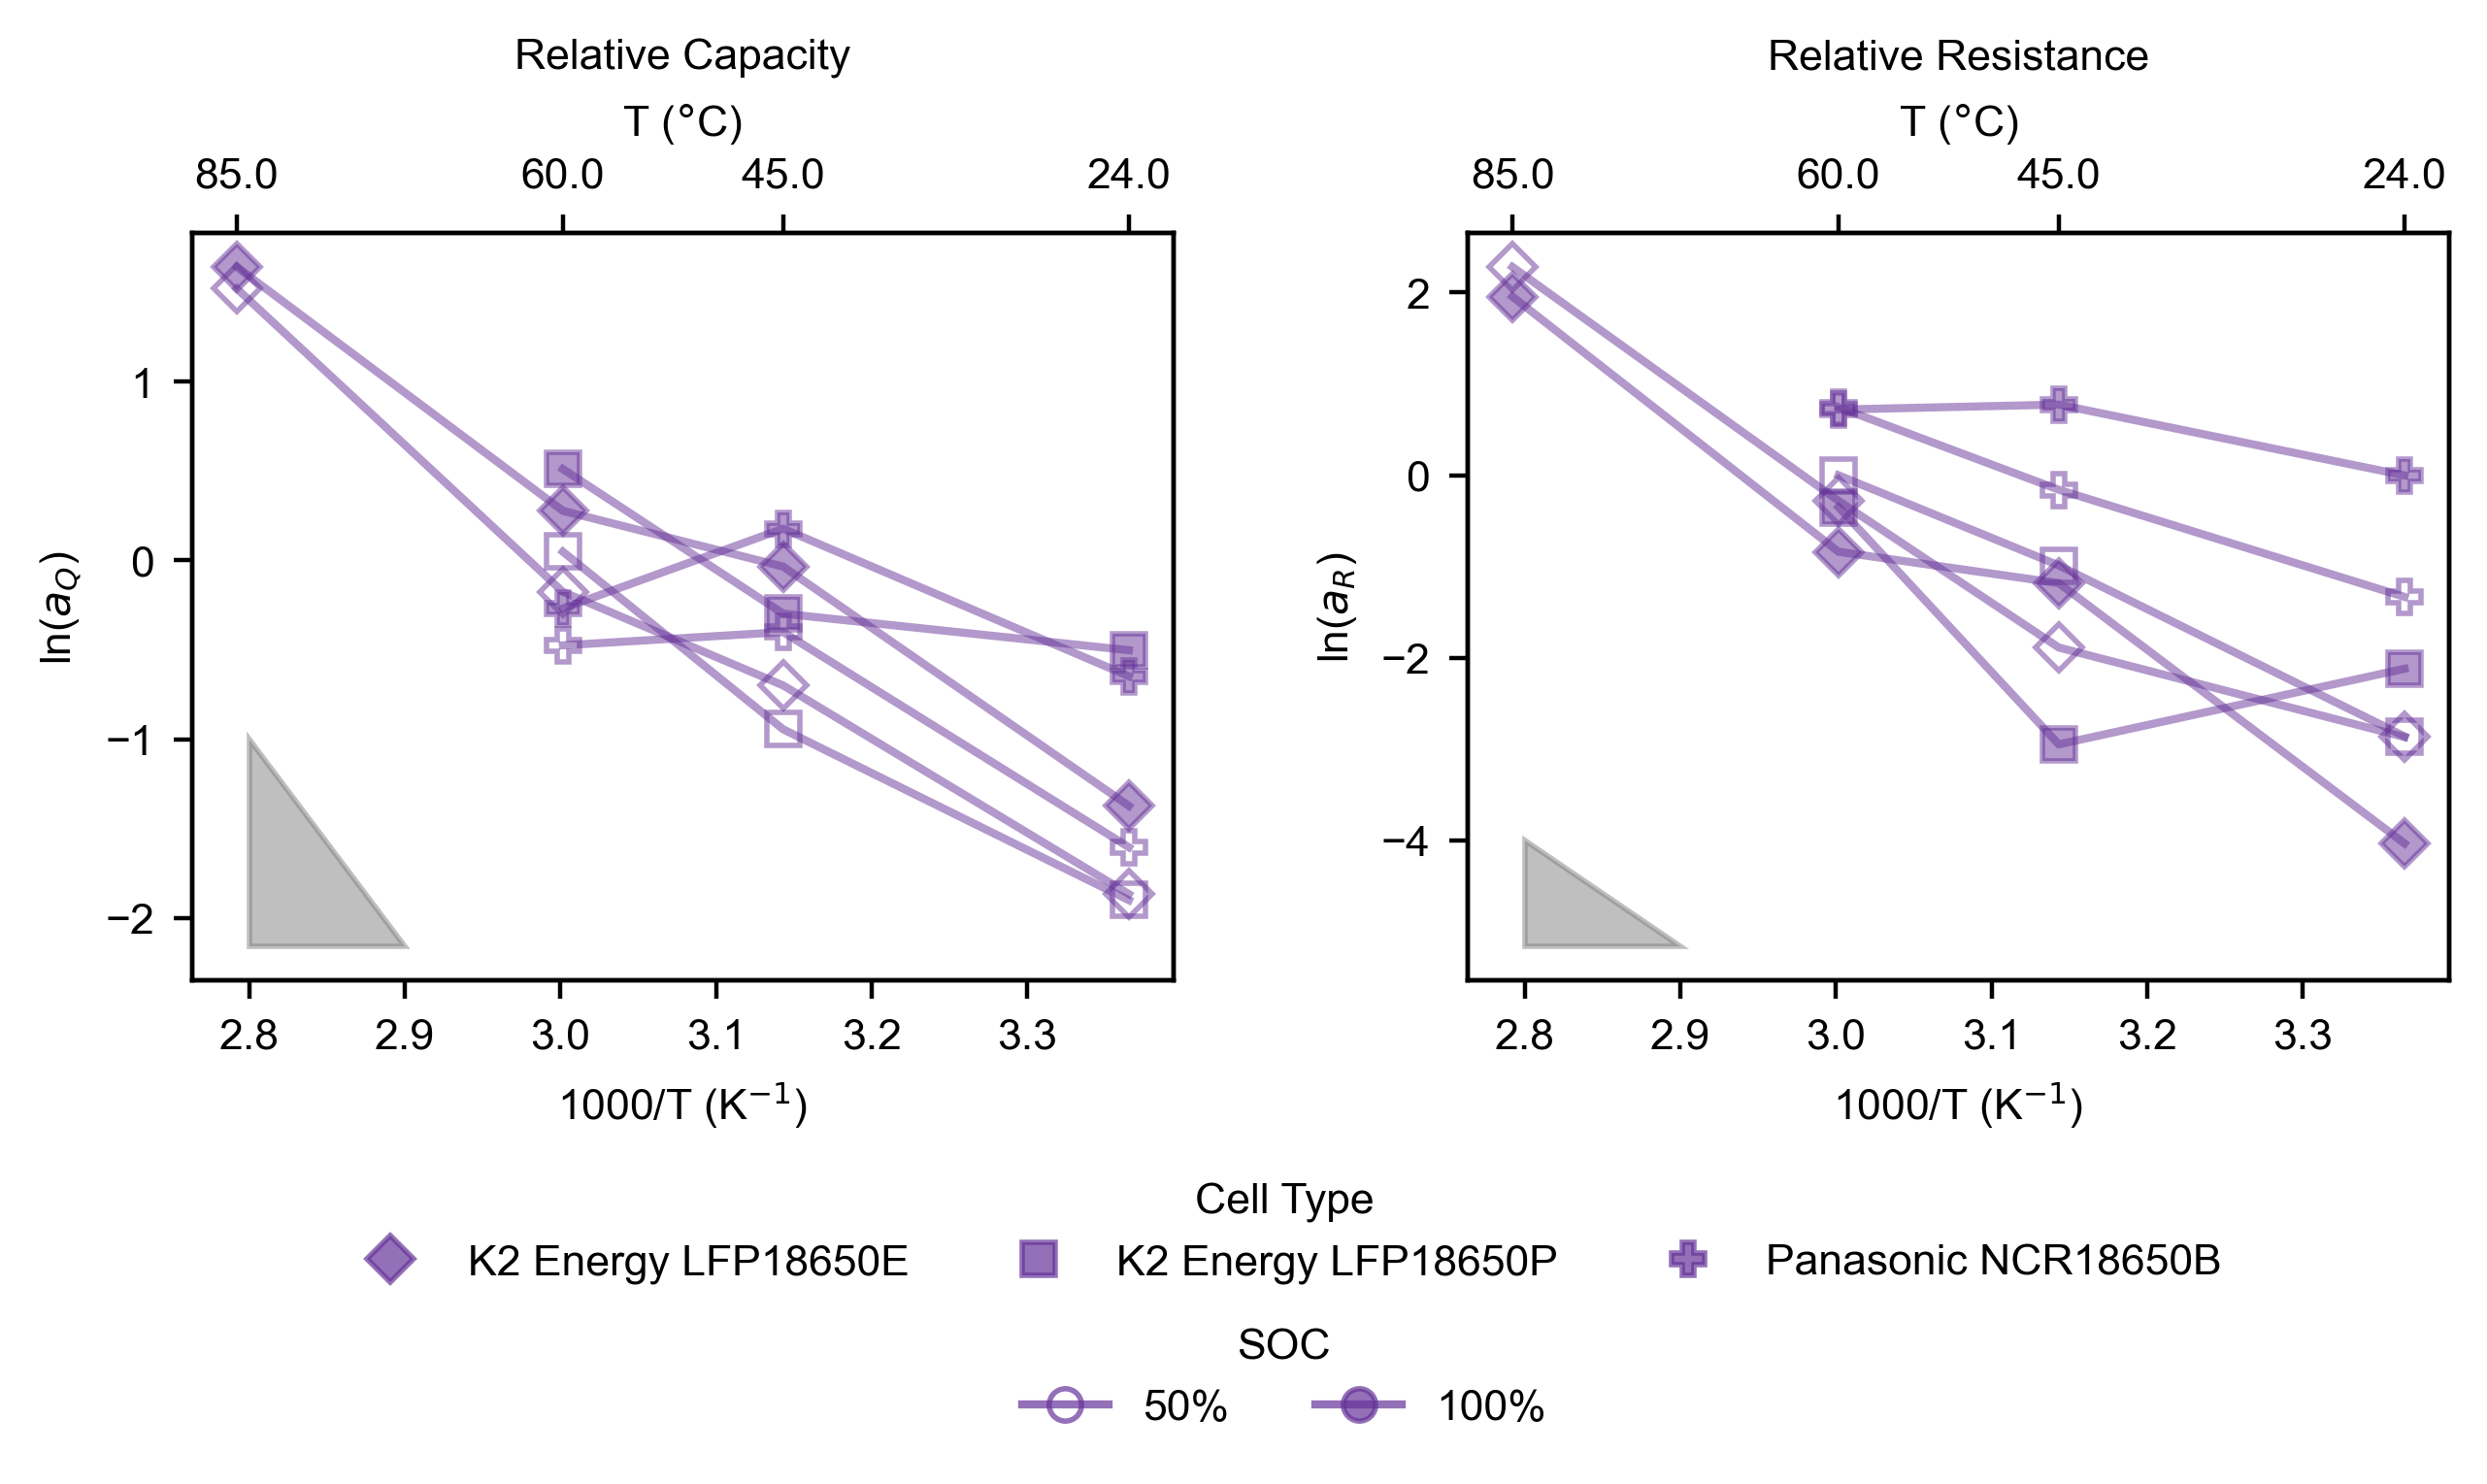

In [10]:
#Plot mean(ln(a)) vs 1/T for capacity and resistance


#This function to help transform axis between top and bottom
def inverse_T(x):
    return 1000/(x+273.15)

#Can change this to 2 to show cells with only 2 tested temperatures
min_temps = 3 

fig, axs = plt.subplots(1,2, figsize=(7.5, 2.5), dpi=400)
ax=axs[0]
for cell_type in cell_type_list:
    cell_type_df = tx_cap_fitting_df[tx_cap_fitting_df["Cell_type"]==cell_type]
    for soc in set(cell_type_df["SOC"]):
        cell_type_set_soc_df = cell_type_df[cell_type_df["SOC"]==soc]
        mean_df = cell_type_set_soc_df.groupby("inverse_T(K)")["log_a"].mean().reset_index()
        if len(mean_df) < min_temps:
            continue
        marker_kwargs = {"marker": cell_type_marker_dict[cell_type], "fillstyle":soc_fill_dict[soc], 
                    "color":"rebeccapurple", "alpha":0.5}
        ax.plot(mean_df["inverse_T(K)"]*1000,mean_df["log_a"], **marker_kwargs)

ax.set_title("Relative Capacity")
ax.set_xlabel(r"1000/T (K$^{-1}$)")
ax.set_ylabel(r"ln($a_Q$)")


#Plotting 1eV slope
ev = 1
ev_slope = -1*ev/KB_EV
start_y = -1
start_x = 0.0028
delta = 0.0001
x = np.array([start_x, start_x, start_x+delta])*1000 #1000 to make it 1000/T
y = [start_y, start_y+ev_slope*delta, start_y+ev_slope*delta]
ax.fill(x, y, color="gray", alpha=0.5)

#This is for adding top label
ax_twin = ax.twiny()
ax_twin.set_xlim(ax.get_xlim())
ax_twin.set_xlabel(r"T ($\degree$C)")

x_ticks = np.array([24, 45, 60, 85])  # Define the desired tick positions
ax_twin.set_xticks(inverse_T(x_ticks))  # Convert tick positions using the forward transformation
ax_twin.set_xticklabels([f'{tick:.1f}' for tick in x_ticks])  # Set tick labels


ax=axs[1]
for cell_type in cell_type_list:
    cell_type_df = tx_resistance_df[tx_resistance_df["Cell_type"]==cell_type]
    for soc in set(cell_type_df["SOC"]):
        cell_type_set_soc_df = cell_type_df[cell_type_df["SOC"]==soc]
        mean_df = cell_type_set_soc_df.groupby("inverse_T(K)")["log_a"].mean().reset_index()
        if len(mean_df) < min_temps:
            continue
        marker_kwargs = {"marker": cell_type_marker_dict[cell_type], "fillstyle":soc_fill_dict[soc], 
                    "color":"rebeccapurple", "alpha":0.5}
        ax.plot(mean_df["inverse_T(K)"]*1000,mean_df["log_a"], **marker_kwargs)


ax.set_title("Relative Resistance")
ax.set_xlabel(r"1000/T (K$^{-1}$)")
ax.set_ylabel(r"ln($a_R$)")

#Plotting 1eV slope
ev = 1
ev_slope = -1*ev/KB_EV
start_y = -4
start_x = 0.0028
delta = 0.0001
x = np.array([start_x, start_x, start_x+delta])*1000 #1000 to make it 1000/T
y = [start_y, start_y+ev_slope*delta, start_y+ev_slope*delta]
ax.fill(x, y, color="gray", alpha=0.5)

#This is for adding top label
ax_twin = ax.twiny()

ax_twin.set_xlim(ax.get_xlim())
ax_twin.set_xlabel(r"T ($\degree$C)")

x_ticks = np.array([24, 45, 60, 85])  # Define the desired tick positions
ax_twin.set_xticks(inverse_T(x_ticks))  # Convert tick positions using the forward transformation
ax_twin.set_xticklabels([f'{tick:.1f}' for tick in x_ticks])  # Set tick labels

plt.subplots_adjust(wspace=0.3)

### Add legend
color = "rebeccapurple"

cell_type_handles = []
reduced_cell_type_list = ["K2 Energy LFP18650E","K2 Energy LFP18650P", 'Panasonic NCR18650B']
for cell_type in reduced_cell_type_list:
    cell_type_handles.append(Line2D([0], [0],label='{}'.format(cell_type),color=color, alpha=0.7, 
                    fillstyle="full",marker=cell_type_marker_dict[cell_type], linestyle="None"))

fig.legend(handles=cell_type_handles,bbox_to_anchor=(0.5, -0.15), loc="center", title="Cell Type", frameon=False, ncols=3)

line_soc_50 = Line2D([0], [0], label='50%', alpha=0.7, color=color, marker="o", fillstyle="none")
line_soc_100 = Line2D([0], [0], label='100%', alpha=0.7, color=color, marker="o", fillstyle="full")
soc_handles = [line_soc_50, line_soc_100]
fig.legend(handles=soc_handles, bbox_to_anchor=(0.5, -0.3), loc="center", ncol=2, title= "SOC", frameon=False)


#fig.savefig("../figures/figure3_ArrheniusPlot_aQ_aR.svg", format="svg", transparent=True, bbox_inches="tight")

# Display the figure
plt.show()


In [11]:
def get_activation_energy(cell_type_set_soc_df, ci_alpha, return_slope_int=False, exclude_temp=[]):
    """
    This function will extract the activation energy and give the confidence interval using
    WLS such that each temperature has equal weight. Weight of a data point at each temperature
    is 1/num data points. So is 4 at 60C, 3 at 45C, each data point in 60C is 1/4 weighted, and 
    each data point in 45C is 1/3 weighted so that each temperature is weighted equally.

    @tx_fitting_df(pd.DataFrame): DataFrame filtered to be the correct cell type and soc 
                with columns of "log_a", "inverse_T" (1/K), and Temperature (C)
    @cell_type(str): Cell type to perform this analysis on
    @soc(int): SOC to perform this analysis on
    @ci_alpha(float): Confidence interval alpha. i.e. 0.10 is 90% confidence interval.
    @return_slope_int(Boolean): whether this will return the raw slope and intercept of the fit
    @exlude_temp(list(int)): List of integers of temperatures to exclude from fitting the activation
                energy.

    Returns:
    @ea(float): Activation energy in meV
    @ci_ea(np.array): Confidence interval values of ea [upperbound, lowerbound]
    @slope(float, optional): Slope of fit
    @intercept(float, optional): Intercept of fit

    """

    KB_EV = 8.617*10**-5 #eV/K

    df_filter = (~cell_type_set_soc_df["Temperature"].isin(exclude_temp)) & (~cell_type_set_soc_df["Temperature"].isna())
    a_temp_df = cell_type_set_soc_df[df_filter].copy(deep=True)

    #find the number of unique of each temperature. make weights of that temperature 1/num temperature datapoints
    weights_dict = a_temp_df["Temperature"].value_counts().to_dict()
    for key in weights_dict.keys():
        weights_dict[key] = 1/weights_dict[key]

    #add weights proportional to each of the temperatures total datapoints
    a_temp_df["weights"] = a_temp_df['Temperature'].map(weights_dict)

    unique_temp_data_points = len(a_temp_df["Temperature"].unique())
    
    if unique_temp_data_points<2:
        raise ValueError("Insuffecient Data to extract slope")

    #perform WLS
    X = np.array(a_temp_df["inverse_T(K)"])
    #Add constant needed to fit intercept
    X = sm.add_constant(X)
    Y = np.array(a_temp_df["log_a"])
    wls_model = sm.WLS(Y,X, weights=np.array(a_temp_df["weights"]))
    wls_results = wls_model.fit()

    #Get CI from model
    conf_int = wls_results.conf_int(alpha=ci_alpha)
    conf_int_slope = conf_int[1]
    slope = wls_results.params[1]
    #the intercept is just ignored and not used
    intercept = wls_results.params[0]

    #convert slope to meV
    ea = -1*slope*KB_EV*1000
    ci_ea = -1*conf_int_slope*KB_EV*1000

    if return_slope_int:
        return ea, ci_ea, slope, intercept
    else:
        return ea, ci_ea
    


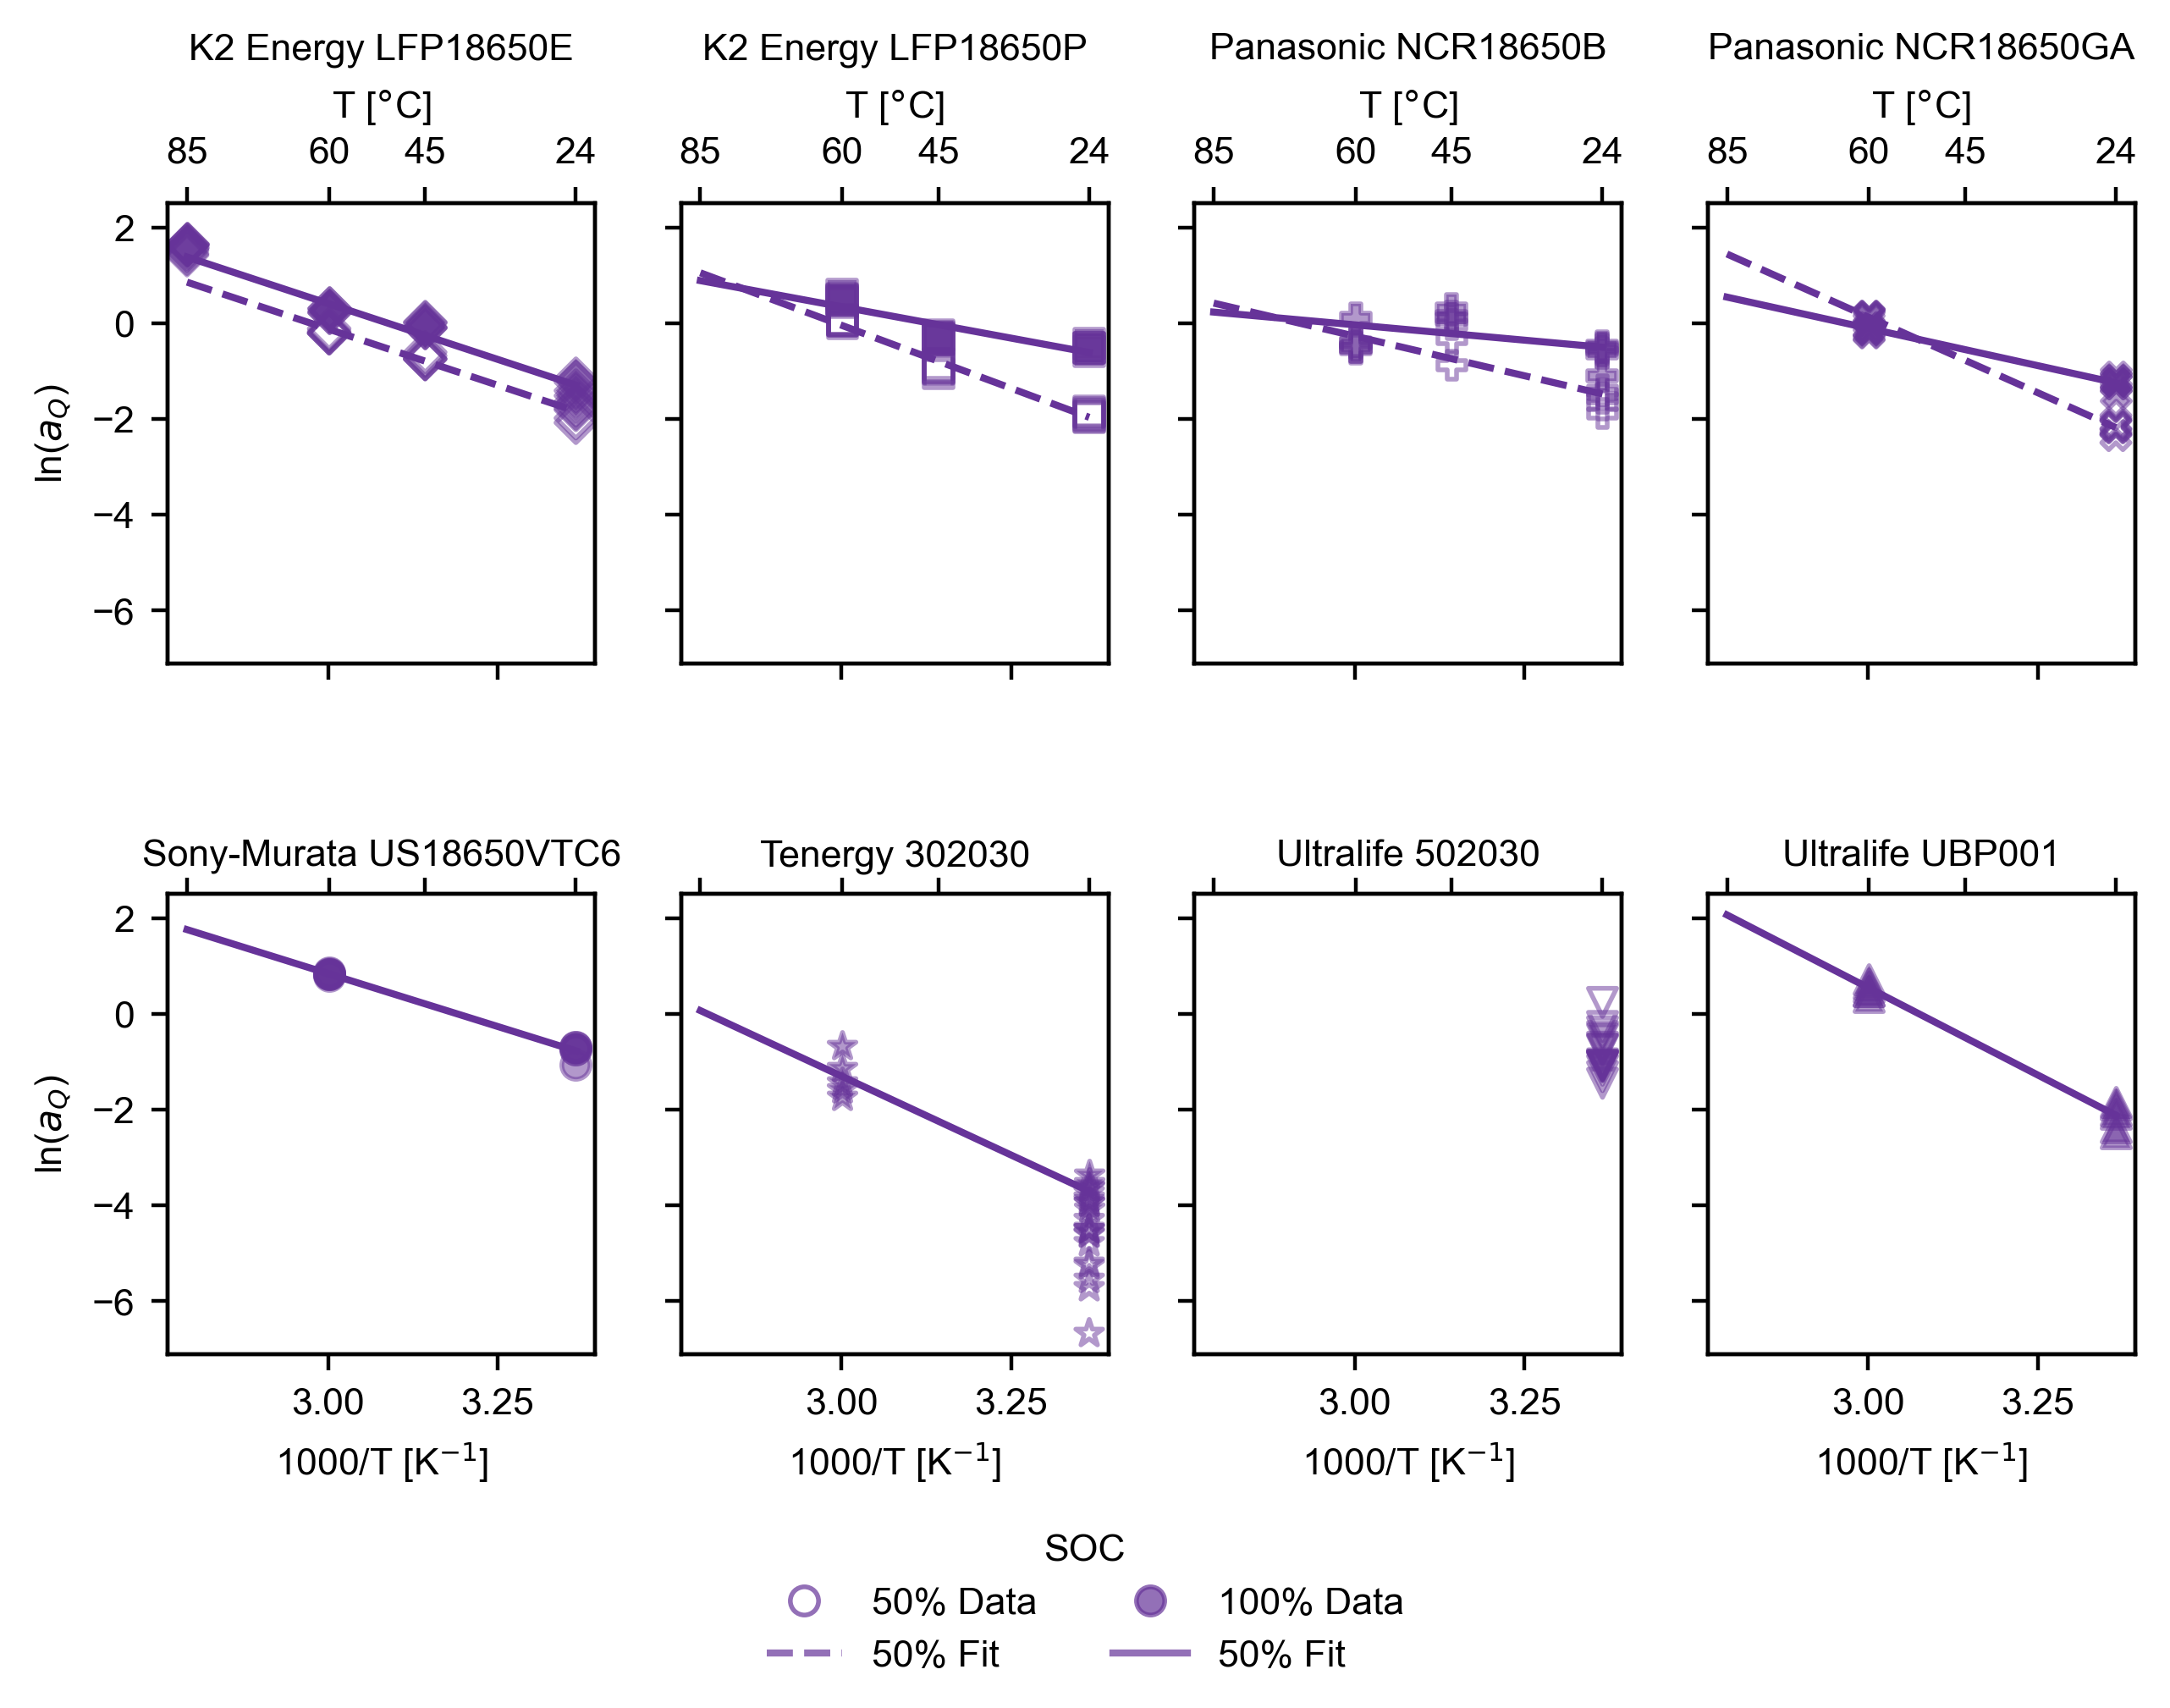

In [12]:
#### Plot all the Capacity data points and fit WLS to get the CI and activation energy. This 
#### cell and the next cell make needed SI figures to make the Arrhenius energy figure. 
#### This cell important gets the ea_cap_wls_df

#Capacity with confidence interval using WLS
cell_type_ea_list = []
soc_ea_list = []
ea_list = []
ci_ea_list = []
a0_list = []

soc_scatter_fill_dict = {50: "none", 100: "rebeccapurple"}
linestyle_dict = {50:"--", 100:"-"}

soc_scatter_fill_dict = {50: "none", 100: "rebeccapurple"}

fig, axs = plt.subplots(2,4, figsize=(7.5, 5), dpi=400, sharey=True, sharex=True)
axs = axs.ravel()

axs_idx = 0
for cell_type in cell_type_list:
    cell_type_df = tx_cap_fitting_df[tx_cap_fitting_df["Cell_type"]==cell_type]
    ax = axs[axs_idx]
    ax.set_title(cell_type)
    for soc in set(cell_type_df["SOC"]):
        cell_type_set_soc_df = cell_type_df[cell_type_df["SOC"]==soc]

        marker_kwargs = {"marker": cell_type_marker_dict[cell_type], "facecolors":soc_scatter_fill_dict[soc], 
            "color":"rebeccapurple", "alpha":0.5}

        ax.scatter(cell_type_set_soc_df["inverse_T(K)"]*1000, cell_type_set_soc_df["log_a"], **marker_kwargs)
                
        #Draw line of best fit
        try:
            ea, ci_alpha, slope, intercept = get_activation_energy(cell_type_set_soc_df, 0.10, return_slope_int=True, 
                                                                    exclude_temp=[85])
        #Throws value error if insufficient data to perform a fit (1 temperature datapoint)
        except ValueError:
            continue


        ea_list.append(ea)
        ci_ea_list.append(ci_alpha)
        cell_type_ea_list.append(cell_type)
        soc_ea_list.append(soc)

        
        lowerx = 1/(85+CELCIUS_TO_KELVIN)
        upperx = 1/(24+CELCIUS_TO_KELVIN)
        x = np.linspace(lowerx, upperx, 10)
        ax.plot(x*1000, slope*x+intercept, linestyle = linestyle_dict[soc], color="rebeccapurple")
    
    #This is for adding top label
    ax_twin = ax.twiny()
    #transform to bottom axis
    def inverse_T(x):
        return 1000/(x+273.15)

    ax_twin.set_xlim(ax.get_xlim())
    

    x_ticks = np.array([24, 45, 60, 85])  # Define the desired tick positions
    ax_twin.set_xticks(inverse_T(x_ticks))  # Convert tick positions using the forward transformation
    #only put the numbers on the top row
    if axs_idx<4:
        ax_twin.set_xlabel(r"T [$\degree$C]")
        ax_twin.set_xticklabels([f'{tick:.0f}' for tick in x_ticks])  # Set tick labels
    else:
        ax_twin.set_xticklabels([])
    
    #Move to next figure
    axs_idx+=1


#Make df for barplot
ea_cap_wls_df = pd.DataFrame({"Cell_type": cell_type_ea_list, "soc": soc_ea_list, "Ea(meV)": ea_list, "CI_ea(meV)": ci_ea_list})


plt.subplots_adjust(hspace=0.5)
axs[0].set_ylabel(r"ln($a_Q$)")
axs[4].set_ylabel(r"ln($a_Q$)")

axs[4].set_xlabel("1000/T [K$^{-1}$]")
axs[5].set_xlabel("1000/T [K$^{-1}$]")
axs[6].set_xlabel("1000/T [K$^{-1}$]")
axs[7].set_xlabel("1000/T [K$^{-1}$]")

#add in legend
data_soc_50 = Line2D([0], [0], label='50% Data', alpha=0.7, color="rebeccapurple", marker="o", fillstyle="none", linestyle="none")
data_soc_100 = Line2D([0], [0], label='100% Data', alpha=0.7, color="rebeccapurple", marker="o", fillstyle="full", linestyle="none")
fit_soc_50 =  Line2D([0], [0], label='50% Fit', alpha=0.7, color="rebeccapurple", linestyle="--")
fit_soc_100 =  Line2D([0], [0], label='50% Fit', alpha=0.7, color="rebeccapurple", linestyle="-")

soc_handles = [data_soc_50, fit_soc_50, data_soc_100, fit_soc_100]
fig.legend(handles=soc_handles, loc="lower center", ncol=2, title="SOC", frameon=False)
plt.subplots_adjust(bottom=0.2)

#fig.savefig("../figures/SI_figure_cap_ea_extraction_individual.pdf", format="pdf", transparent=True, bbox_inches="tight")


/var/folders/k9/hy9cs3b54pq88xpmlpdhl3c40000gn/T/ipykernel_81099/4069033996.py:50: RuntimeWarning: invalid value encountered in add
  ax.plot(x*1000, slope*x+intercept, linestyle = linestyle_dict[soc], color="rebeccapurple")


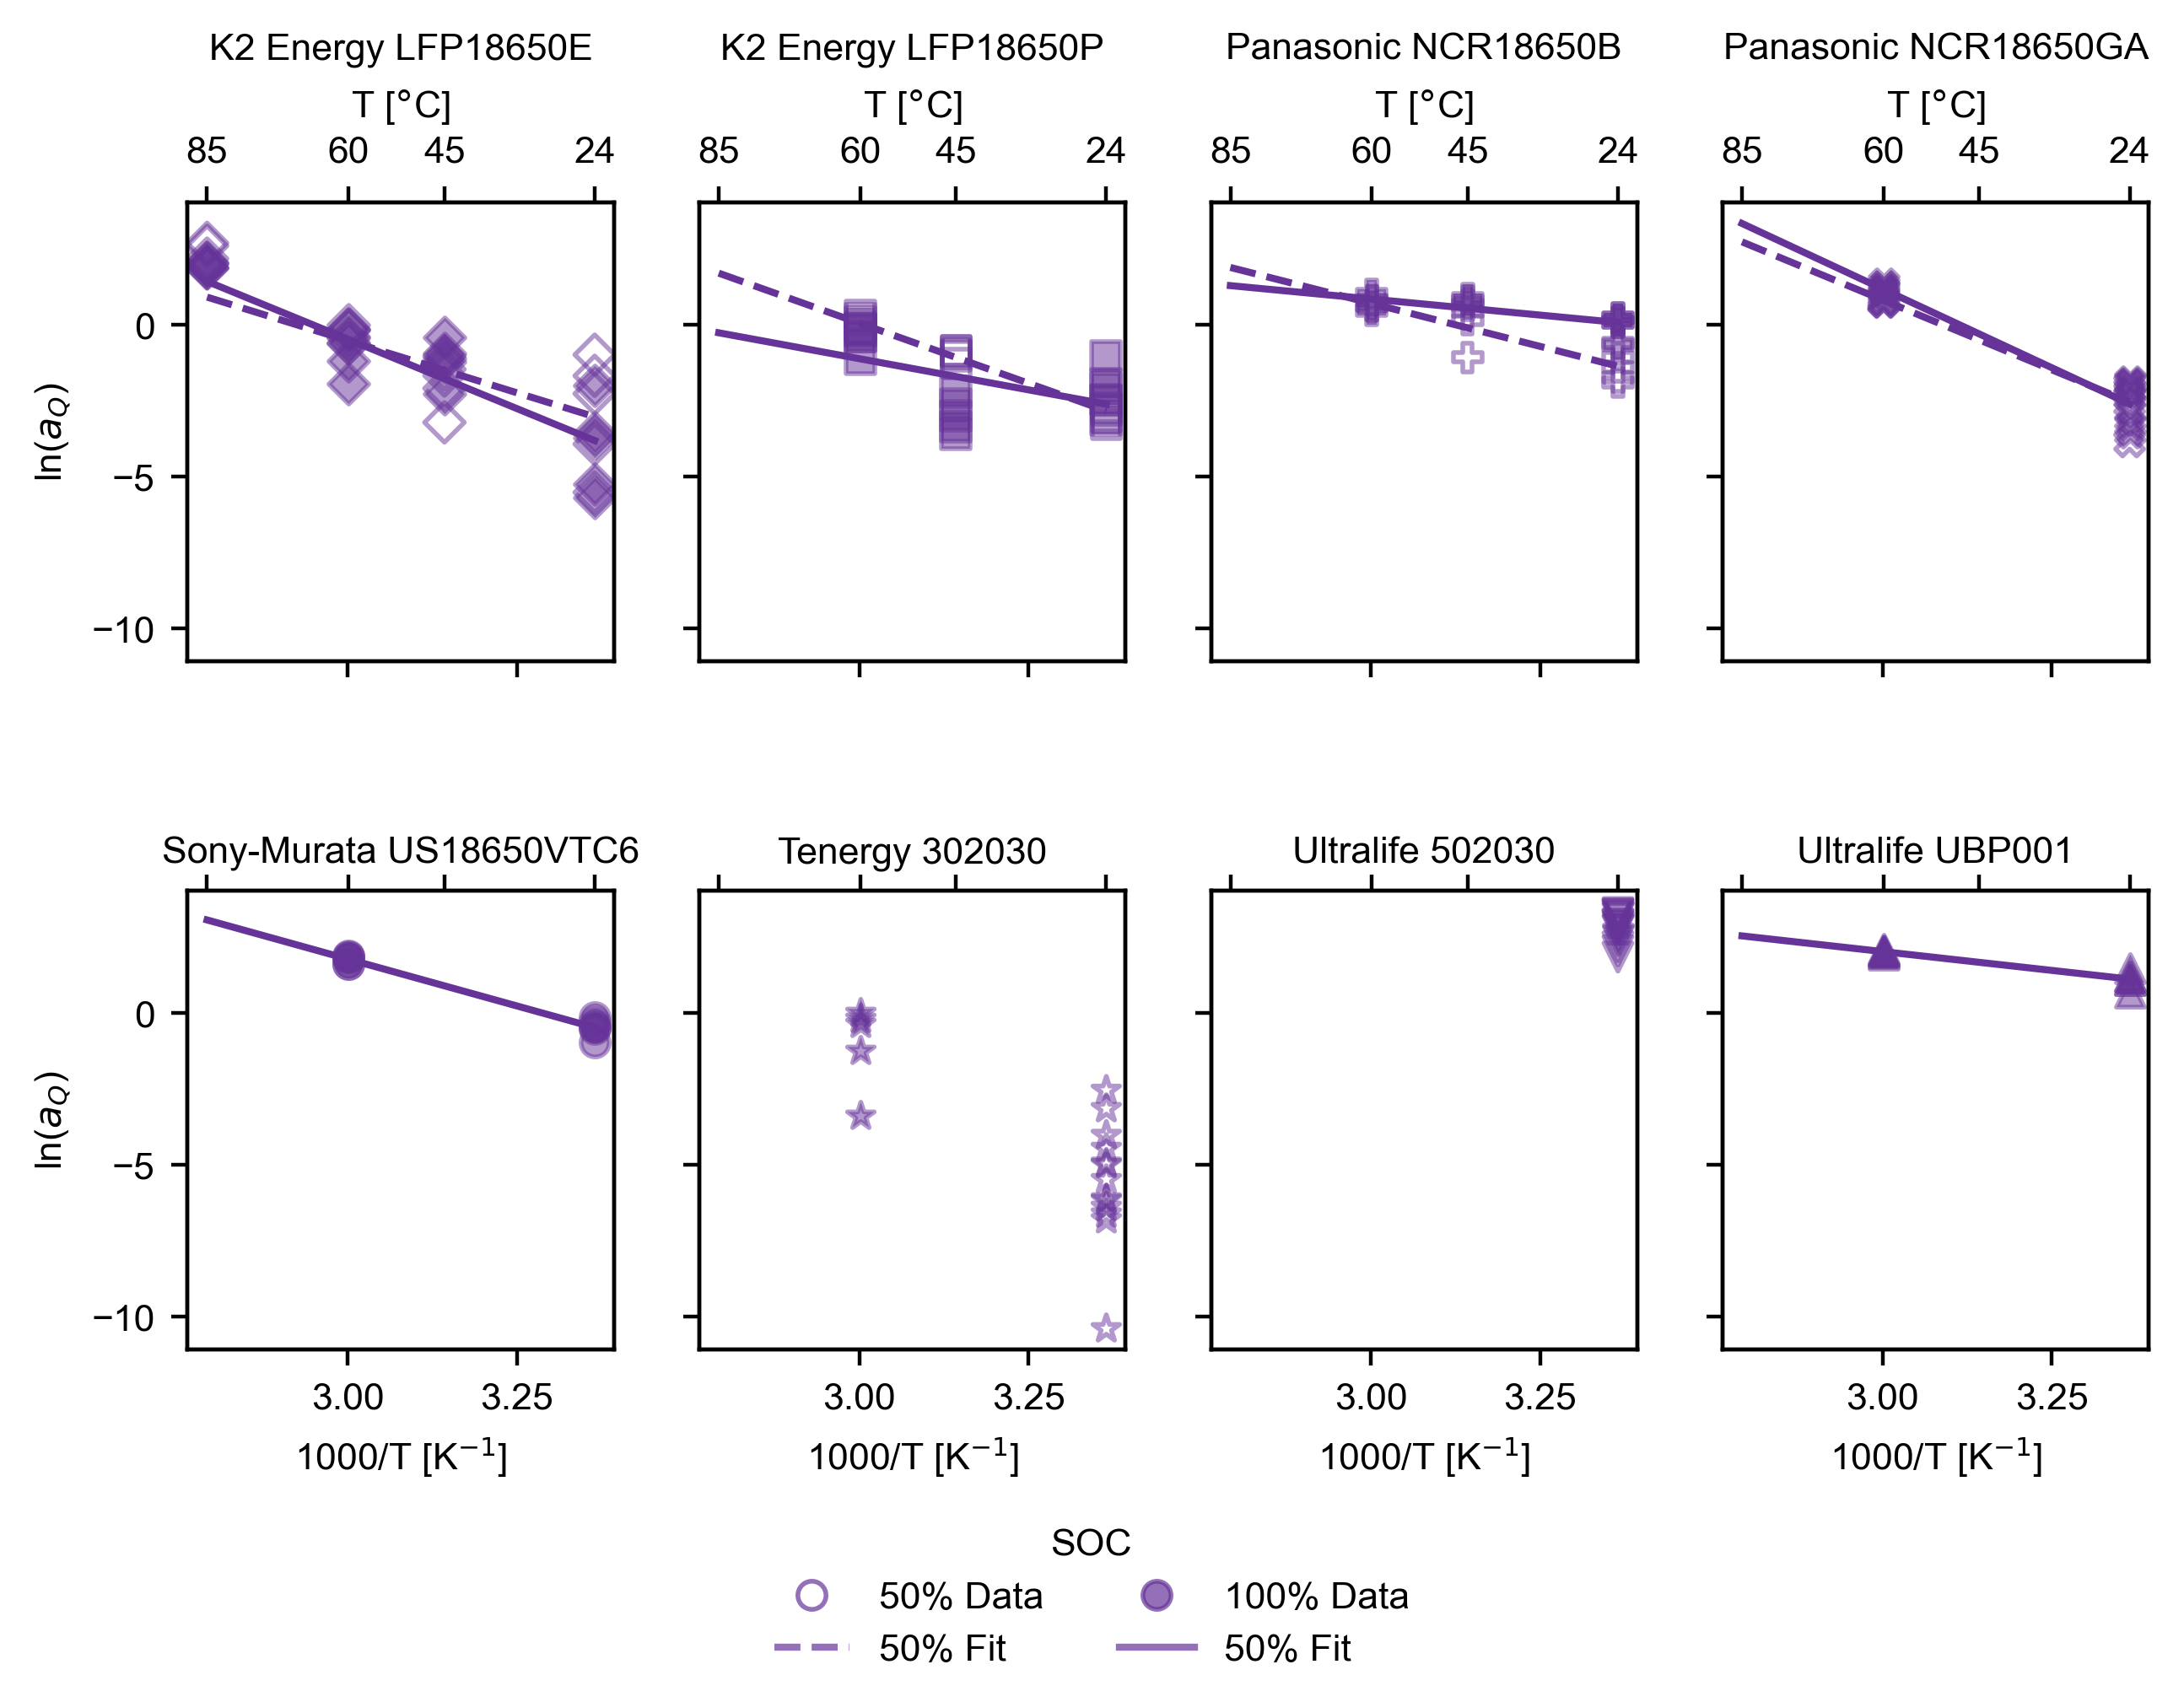

In [13]:
#### Plot all the Resistance data points and fit WLS to get the CI and activation energy. This 
#### cell and the above cell are needed SI figures to make the Arrhenius energy figure.
#### This cell important gets the ea_res_wls_df

cell_type_ea_list = []
soc_ea_list = []
ea_list = []
ci_ea_list = []
a0_list = []

soc_scatter_fill_dict = {50: "none", 100: "rebeccapurple"}
linestyle_dict = {50:"--", 100:"-"}

soc_scatter_fill_dict = {50: "none", 100: "rebeccapurple"}

fig, axs = plt.subplots(2,4, figsize=(7.5, 5), dpi=400, sharey=True, sharex=True)
axs = axs.ravel()

axs_idx = 0
for cell_type in cell_type_list:
    cell_type_df = tx_resistance_df[tx_resistance_df["Cell_type"]==cell_type]
    ax = axs[axs_idx]
    ax.set_title(cell_type)
    for soc in set(cell_type_df["SOC"]):
        cell_type_set_soc_df = cell_type_df[cell_type_df["SOC"]==soc]

        marker_kwargs = {"marker": cell_type_marker_dict[cell_type], "facecolors":soc_scatter_fill_dict[soc], 
            "color":"rebeccapurple", "alpha":0.5}

        ax.scatter(cell_type_set_soc_df["inverse_T(K)"]*1000, cell_type_set_soc_df["log_a"], **marker_kwargs)
                
        #Draw line of best fit
        try:
            ea, ci_alpha, slope, intercept = get_activation_energy(cell_type_set_soc_df, 0.10, return_slope_int=True, 
                                                                    exclude_temp=[85])
        #Throws value error if insufficient data to perform a fit (1 temperature datapoint)
        except ValueError:
            continue


        ea_list.append(ea)
        ci_ea_list.append(ci_alpha)
        cell_type_ea_list.append(cell_type)
        soc_ea_list.append(soc)

        
        lowerx = 1/(85+CELCIUS_TO_KELVIN)
        upperx = 1/(24+CELCIUS_TO_KELVIN)
        x = np.linspace(lowerx, upperx, 10)
        ax.plot(x*1000, slope*x+intercept, linestyle = linestyle_dict[soc], color="rebeccapurple")
    
    #This is for adding top label
    ax_twin = ax.twiny()
    #transform to bottom axis
    def inverse_T(x):
        return 1000/(x+273.15)

    ax_twin.set_xlim(ax.get_xlim())
    

    x_ticks = np.array([24, 45, 60, 85])  # Define the desired tick positions
    ax_twin.set_xticks(inverse_T(x_ticks))  # Convert tick positions using the forward transformation
    #only put the numbers on the top row
    if axs_idx<4:
        ax_twin.set_xlabel(r"T [$\degree$C]")
        ax_twin.set_xticklabels([f'{tick:.0f}' for tick in x_ticks])  # Set tick labels
    else:
        ax_twin.set_xticklabels([])
    
    #Move to next figure
    axs_idx+=1


#Make df for barplot
ea_res_wls_df = pd.DataFrame({"Cell_type": cell_type_ea_list, "soc": soc_ea_list, "Ea(meV)": ea_list, "CI_ea(meV)": ci_ea_list})


plt.subplots_adjust(hspace=0.5)
axs[0].set_ylabel(r"ln($a_Q$)")
axs[4].set_ylabel(r"ln($a_Q$)")

axs[4].set_xlabel("1000/T [K$^{-1}$]")
axs[5].set_xlabel("1000/T [K$^{-1}$]")
axs[6].set_xlabel("1000/T [K$^{-1}$]")
axs[7].set_xlabel("1000/T [K$^{-1}$]")

#add in legend
data_soc_50 = Line2D([0], [0], label='50% Data', alpha=0.7, color="rebeccapurple", marker="o", fillstyle="none", linestyle="none")
data_soc_100 = Line2D([0], [0], label='100% Data', alpha=0.7, color="rebeccapurple", marker="o", fillstyle="full", linestyle="none")
fit_soc_50 =  Line2D([0], [0], label='50% Fit', alpha=0.7, color="rebeccapurple", linestyle="--")
fit_soc_100 =  Line2D([0], [0], label='50% Fit', alpha=0.7, color="rebeccapurple", linestyle="-")

soc_handles = [data_soc_50, fit_soc_50, data_soc_100, fit_soc_100]
fig.legend(handles=soc_handles, loc="lower center", ncol=2, title="SOC", frameon=False)
plt.subplots_adjust(bottom=0.2)

#fig.savefig("../figures/SI_figure_res_ea_extraction_individual.pdf", format="pdf", transparent=True, bbox_inches="tight")

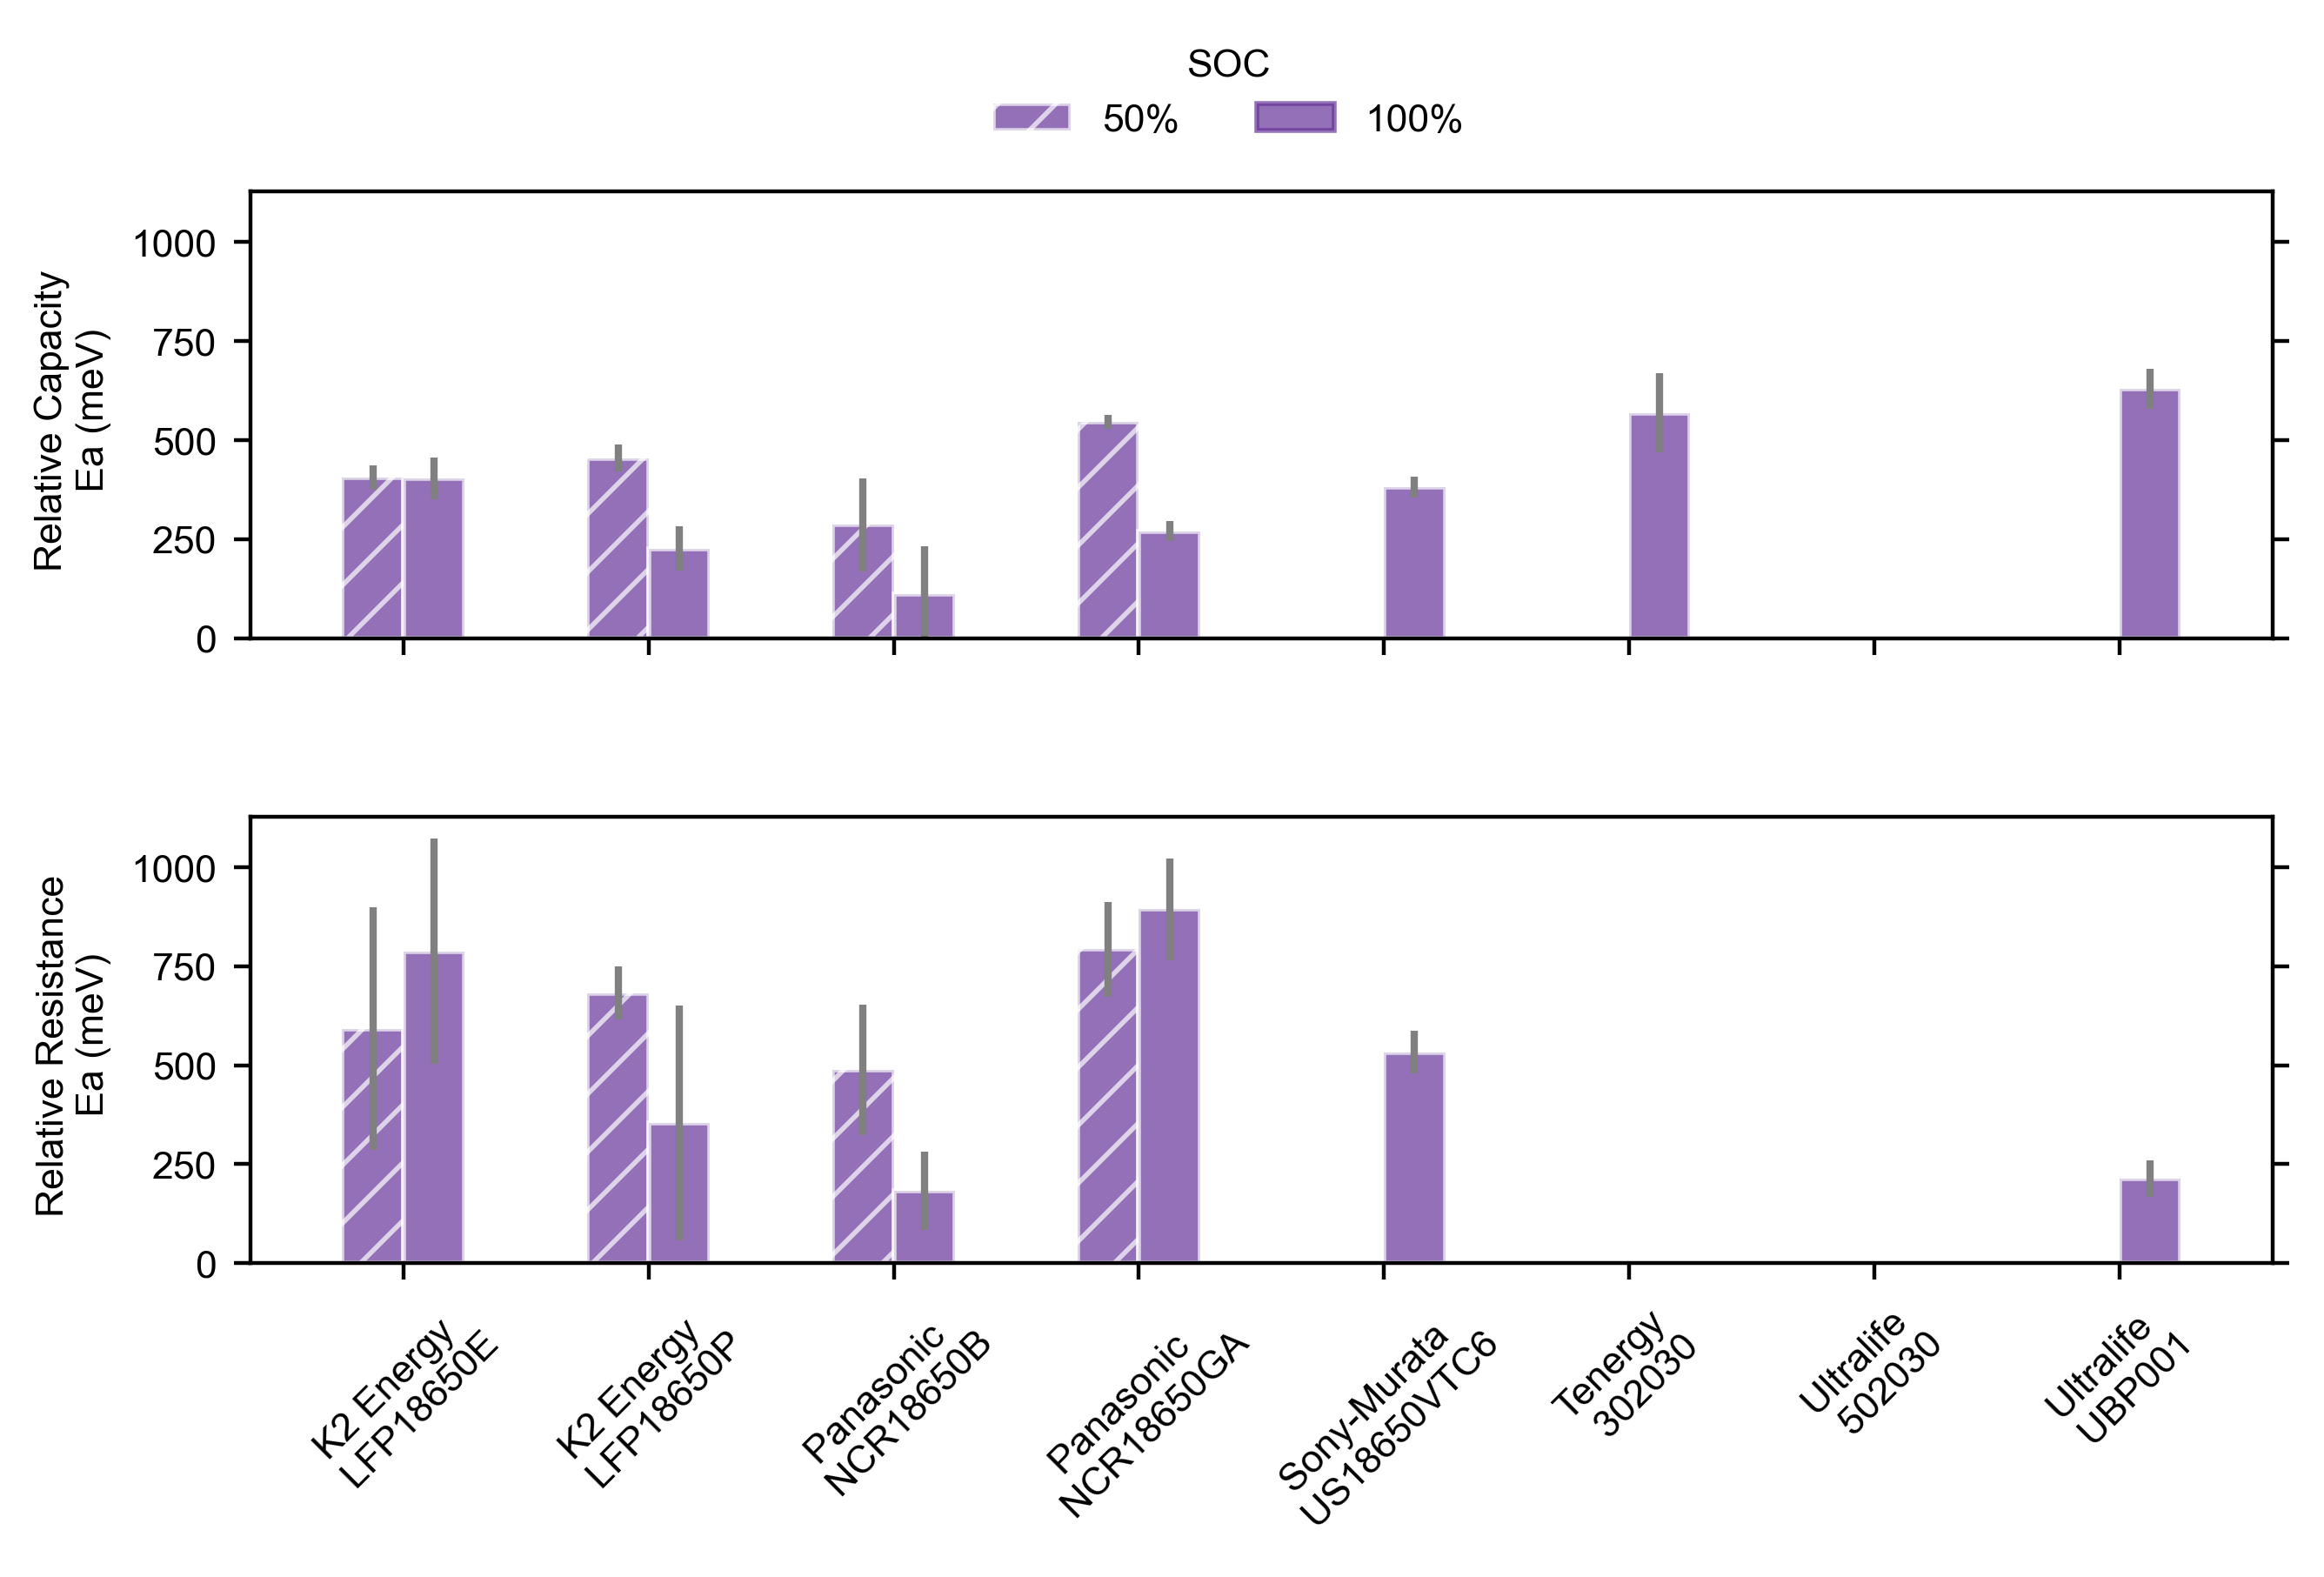

In [14]:
#### With ea_res_wls_df and ea_cap_wls_df we now plot the activaito energy bar plot

                    
fig, axs = plt.subplots(2, 1, figsize=(7.5,4), sharey=True, dpi=400)


#### Capacity bar plot

ax = axs[0]
soc_list = [50, 100]
soc_hatch_style = ["//", ""]

x = np.arange(len(cell_type_list))

color="rebeccapurple"

width=0.25
idx = 0
soc_offset=0
for soc in soc_list:
    
    condition_list = []
    CI_list = []
    for cell_type in cell_type_list[:]:

        condition_df = ea_cap_wls_df[(ea_cap_wls_df["soc"]==soc) & (ea_cap_wls_df["Cell_type"]==cell_type)]

        if len(condition_df)==0:
            condition_list.append(0)
            CI_list.append([0,0])
        else:
            ea = condition_df["Ea(meV)"].iloc[0]
            ci_ea = condition_df["CI_ea(meV)"].iloc[0]
            condition_list.append(condition_df["Ea(meV)"].iloc[0])
            upper = ci_ea[0]-ea
            lower = ea-ci_ea[1]
            CI_list.append([lower, upper])

    CI_array = np.array(CI_list).transpose()
    offset = width*soc_offset
    rects = ax.bar(x + offset, condition_list, width,edgecolor="white",alpha=0.7,ecolor="gray",yerr=CI_array, color=color, 
    hatch=soc_hatch_style[soc_list.index(soc)], label="SOC={}%".format(soc))

    idx+=1
    soc_offset+=1





ax.set_xticks(x + width/2, []*len(x))
ax.yaxis.set_ticks_position('both')
ax.set_ylabel("Relative Capacity \n Ea (meV)")


###### Resistance bar plot

ax = axs[1]

x = np.arange(len(cell_type_list))

width=0.25
idx = 0
soc_offset=0
for soc in soc_list:
    
    condition_list = []
    CI_list = []
    for cell_type in cell_type_list[:]:

        condition_df = ea_res_wls_df[(ea_res_wls_df["soc"]==soc) & (ea_res_wls_df["Cell_type"]==cell_type)]

        if len(condition_df)==0:
            condition_list.append(0)
            CI_list.append([0,0])
        else:
            ea = condition_df["Ea(meV)"].iloc[0]
            ci_ea = condition_df["CI_ea(meV)"].iloc[0]
            condition_list.append(condition_df["Ea(meV)"].iloc[0])
            upper = ci_ea[0]-ea
            lower = ea-ci_ea[1]
            CI_list.append([lower, upper])

    CI_array = np.array(CI_list).transpose()
    offset = width*soc_offset
    rects = ax.bar(x + offset, condition_list, width, edgecolor="white", yerr=CI_array, alpha=0.7, ecolor="gray", color=color, 
    hatch=soc_hatch_style[soc_list.index(soc)], label="SOC={}%".format(soc))

    idx+=1
    soc_offset+=1



new_label_list = []
for old_label in cell_type_list:

    if old_label.split(" ")[0] =="K2":
        new_label = old_label.split(" ")[0]+ " " +old_label.split(" ")[1] + " \n " + old_label.split(" ")[2]

    else:
        new_label = old_label.split(" ")[0] + " \n " + old_label.split(" ")[1]

    new_label_list.append(new_label)


ax.set_xticks(x + width/2, new_label_list, rotation=45)
ax.yaxis.set_ticks_position('both')
ax.set_ylabel("Relative Resistance \n Ea (meV)")
plt.subplots_adjust(hspace=0.4)
plt.gca().set_ylim(bottom=0)



# Adding in legend

patch_soc_50 = mpatches.Patch(facecolor = color, edgecolor='white', label='50%', hatch="//", alpha=0.7)
patch_soc_100 = mpatches.Patch(color=color, label='100%', hatch="", alpha=0.7)

soc_handles = [patch_soc_50, patch_soc_100]


fig.legend(handles=soc_handles, ncol=2, bbox_to_anchor=(0.5, 0.95), loc="center", title= "SOC", frameon=False)

#save fig
#fig.savefig("../figures/figure4_EA_bar_plot.svg", format="svg", transparent=True, bbox_inches="tight")


# Display the figure
plt.show()


## Figure 5, 6
Plot the b bar plot and histogram
Compare the resistance and capacity fitted parameters

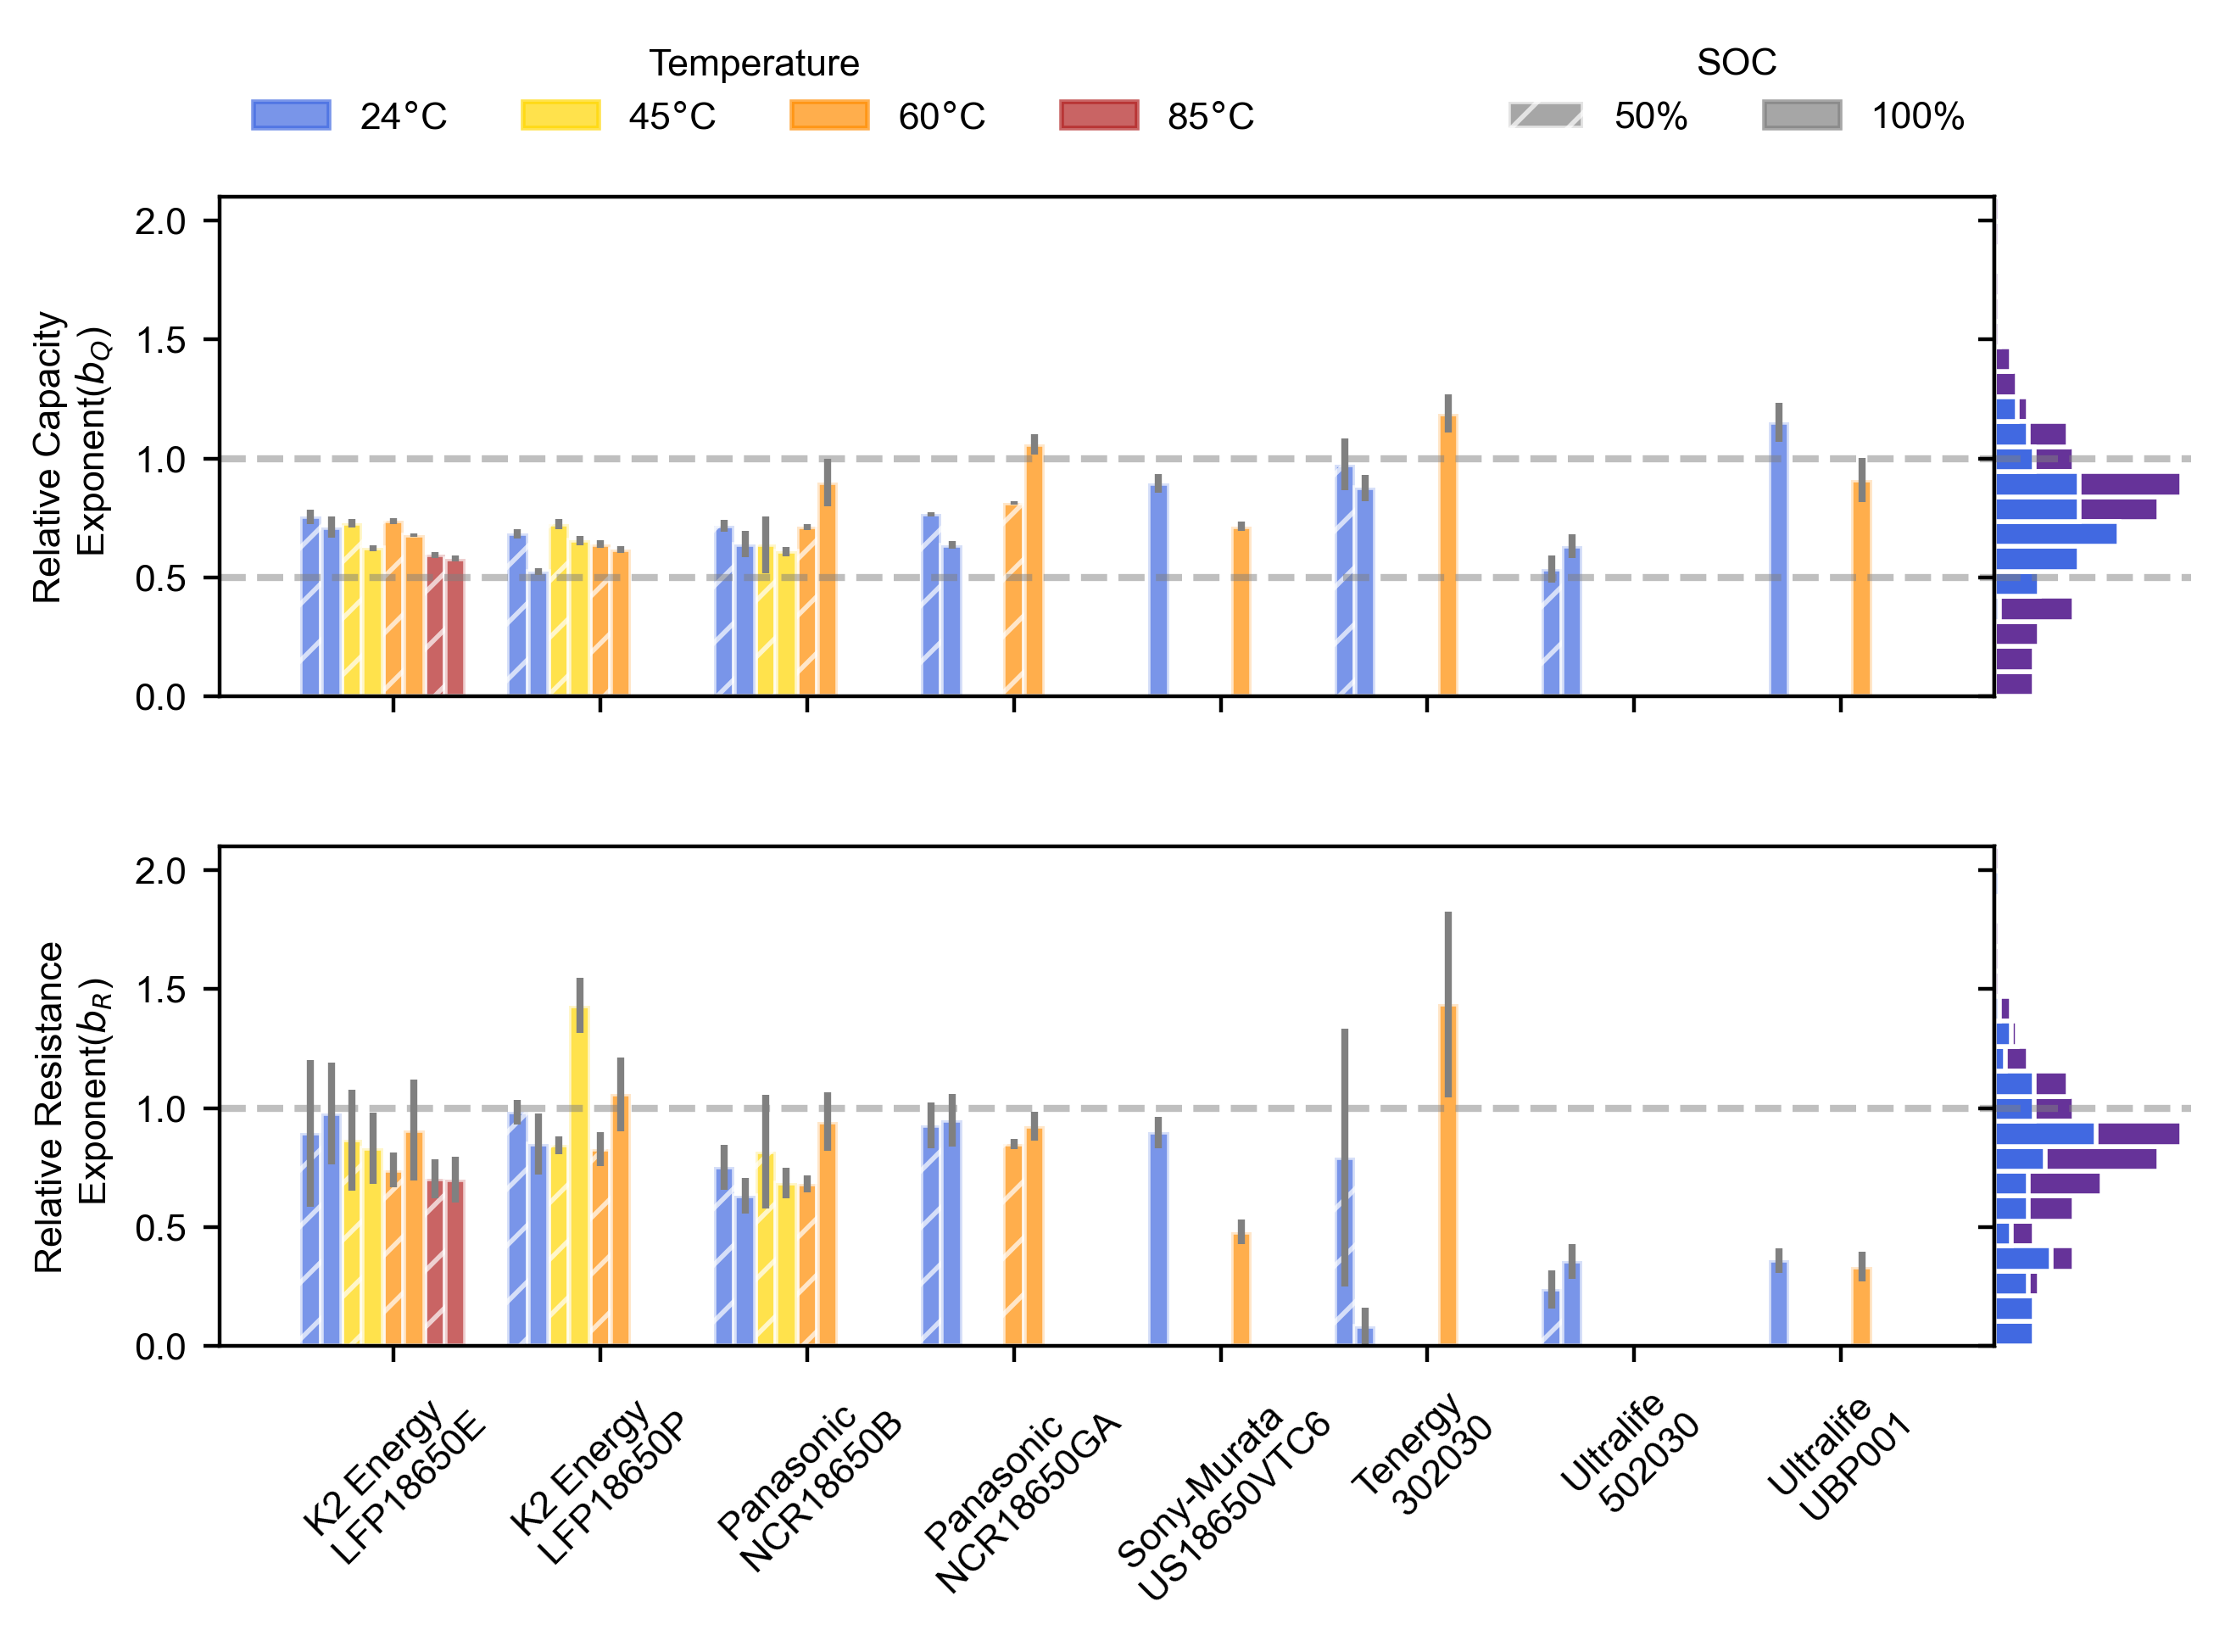

In [16]:
#b value bar plot

#Set up number of figures
axs = [None]*4
#math to make scaling approximately right
fig = plt.figure(figsize=(7.5,4.4), dpi=400)
gs = gridspec.GridSpec(2, 10, wspace = 0)
#top barplot
axs[0] = plt.subplot(gs[0, :9])
#top histogram
axs[1] = plt.subplot(gs[0, 9], sharey = axs[0])
#bottom barplot
axs[2] = plt.subplot(gs[1, :9])
#bottom histogram
axs[3] = plt.subplot(gs[1, 9], sharey = axs[2], sharex = axs[1])


y_range = [0,2.1]
temp_list = [24, 45, 60, 85]
soc_list = [50, 100]
soc_hatch_style = ["//", ""]

width=0.25
x = np.arange(len(cell_type_list))*10*width

color_list = ["royalblue", "gold", "darkorange", "firebrick"]

ax = axs[0]
idx = 0
soc_offset=0
for soc in soc_list:
    temp_offset = 0
    for temp in temp_list:
        
        condition_list = []
        std_list = []
        for cell_type in cell_type_list[:]:

            condition_df = tx_cap_fitting_df[(tx_cap_fitting_df["Temperature"]==temp) & (tx_cap_fitting_df["SOC"]==soc) & (tx_cap_fitting_df["Cell_type"]==cell_type)]

            if len(condition_df)==0:
                condition_list.append(0)
                std_list.append(0)
            else:
                condition_list.append(np.mean(condition_df["b"]))
                std_list.append(np.std(condition_df["b"]))


        offset = width*2 * temp_offset + soc_offset*width
        rects = ax.bar(x + offset, condition_list, width,edgecolor="white",alpha=0.7, color=color_list[temp_list.index(temp)], 
        hatch=soc_hatch_style[soc_list.index(soc)], yerr=std_list, ecolor="grey", label="T={}C, SOC={}%".format(temp, soc))

        temp_offset += 1
        idx+=1

    soc_offset+=1


ax.axhline(0.5, color="gray", alpha=0.5, linestyle="--")
ax.axhline(1, color="gray", alpha=0.5, linestyle="--")

ax.set_xticks(x + 4*width, []*len(x))
ax.set_ylabel("Relative Capacity  \n Exponent" r"($b_Q$)")
ax.set_ylim(y_range)


#plot histogram
ax = axs[1]

b_all = tx_resistance_df["b"]
b_q_24C = tx_cap_fitting_df[tx_cap_fitting_df["Temperature"]==24]["b"]
ax.hist(b_all, bins=20, range = y_range, orientation='horizontal', color='rebeccapurple', edgecolor="white")
ax.hist(b_q_24C, bins=20, range = y_range, orientation='horizontal', color='royalblue', edgecolor="white")
ax.tick_params(axis='y', labelleft=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.xaxis.set_ticks([])
ax.axhline(0.5, color="gray", alpha=0.5, linestyle="--")
ax.axhline(1, color="gray", alpha=0.5, linestyle="--")


###Adding in for Resistance

ax = axs[2]
width=0.25
idx = 0
soc_offset=0
for soc in soc_list:
    temp_offset = 0
    for temp in temp_list:
        
        condition_list = []
        std_list = []
        for cell_type in cell_type_list[:]:

            condition_df = tx_resistance_df[(tx_resistance_df["Temperature"]==temp) & (tx_resistance_df["SOC"]==soc) & (tx_resistance_df["Cell_type"]==cell_type)]

            if len(condition_df)==0:
                condition_list.append(0)
                std_list.append(0)
            else:
                condition_list.append(np.mean(condition_df["b"]))
                std_list.append(np.std(condition_df["b"]))


        offset = width*2 * temp_offset + soc_offset*width
        rects = ax.bar(x + offset, condition_list, width,edgecolor="white",alpha=0.7, color=color_list[temp_list.index(temp)], 
        hatch=soc_hatch_style[soc_list.index(soc)], yerr=std_list, ecolor="grey", label="T={}C, SOC={}%".format(temp, soc))

        temp_offset += 1
        idx+=1

    soc_offset+=1

new_label_list = []
for old_label in cell_type_list:

    if old_label.split(" ")[0] =="K2":
        new_label = old_label.split(" ")[0]+ " " +old_label.split(" ")[1] + " \n " + old_label.split(" ")[2]

    else:
        new_label = old_label.split(" ")[0] + " \n " + old_label.split(" ")[1]

    new_label_list.append(new_label)

ax.axhline(1, color="gray", alpha=0.5, linestyle="--")

ax.set_xticks(x + 4*width, new_label_list, rotation=45)
ax.set_ylabel("Relative Resistance  \n Exponent" r"($b_R$)")
ax.set_ylim(y_range)

#plot histogram
ax = axs[3]

b_all_R = tx_resistance_df["b"]
b_R_24C = tx_resistance_df[tx_resistance_df["Temperature"]==24]["b"]
ax.hist(b_all_R, bins=20, range = y_range, orientation='horizontal', color='rebeccapurple', edgecolor="white")
ax.hist(b_R_24C, bins=20, range = y_range, orientation='horizontal', color='royalblue', edgecolor="white")
ax.tick_params(axis='y', labelleft=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.xaxis.set_ticks([])
ax.axhline(1, color="gray", alpha=0.5, linestyle="--")

plt.subplots_adjust(hspace=0.3)



# Add in legend
patch_24 = mpatches.Patch(color='royalblue', label=r'24$\degree$C', alpha=0.7)
patch_45 = mpatches.Patch(color='gold', label=r'45$\degree$C', alpha=0.7)
patch_60 = mpatches.Patch(color='darkorange', label=r'60$\degree$C', alpha=0.7)
patch_85 = mpatches.Patch(color='firebrick', label=r'85$\degree$C', alpha=0.7)
temp_handles = [patch_24, patch_45, patch_60, patch_85]

patch_soc_50 = mpatches.Patch(facecolor = "gray", edgecolor='white', label='50%', hatch="//", alpha=0.7)
patch_soc_100 = mpatches.Patch(color='gray', label='100%', hatch="", alpha=0.7)
soc_handles = [patch_soc_50, patch_soc_100]

fig.legend(handles=temp_handles, loc='center left', ncol=4, title="Temperature",bbox_to_anchor=(0.125, 0.95), frameon=False)
fig.legend(handles=soc_handles, ncol=2, loc="center right",bbox_to_anchor=(0.825, 0.95), title= "SOC", frameon=False)


#fig.savefig("../figures/figure5_cap_res_b_barplot.svg", format="svg", transparent=True, bbox_inches="tight")

# Display the figure
plt.show()




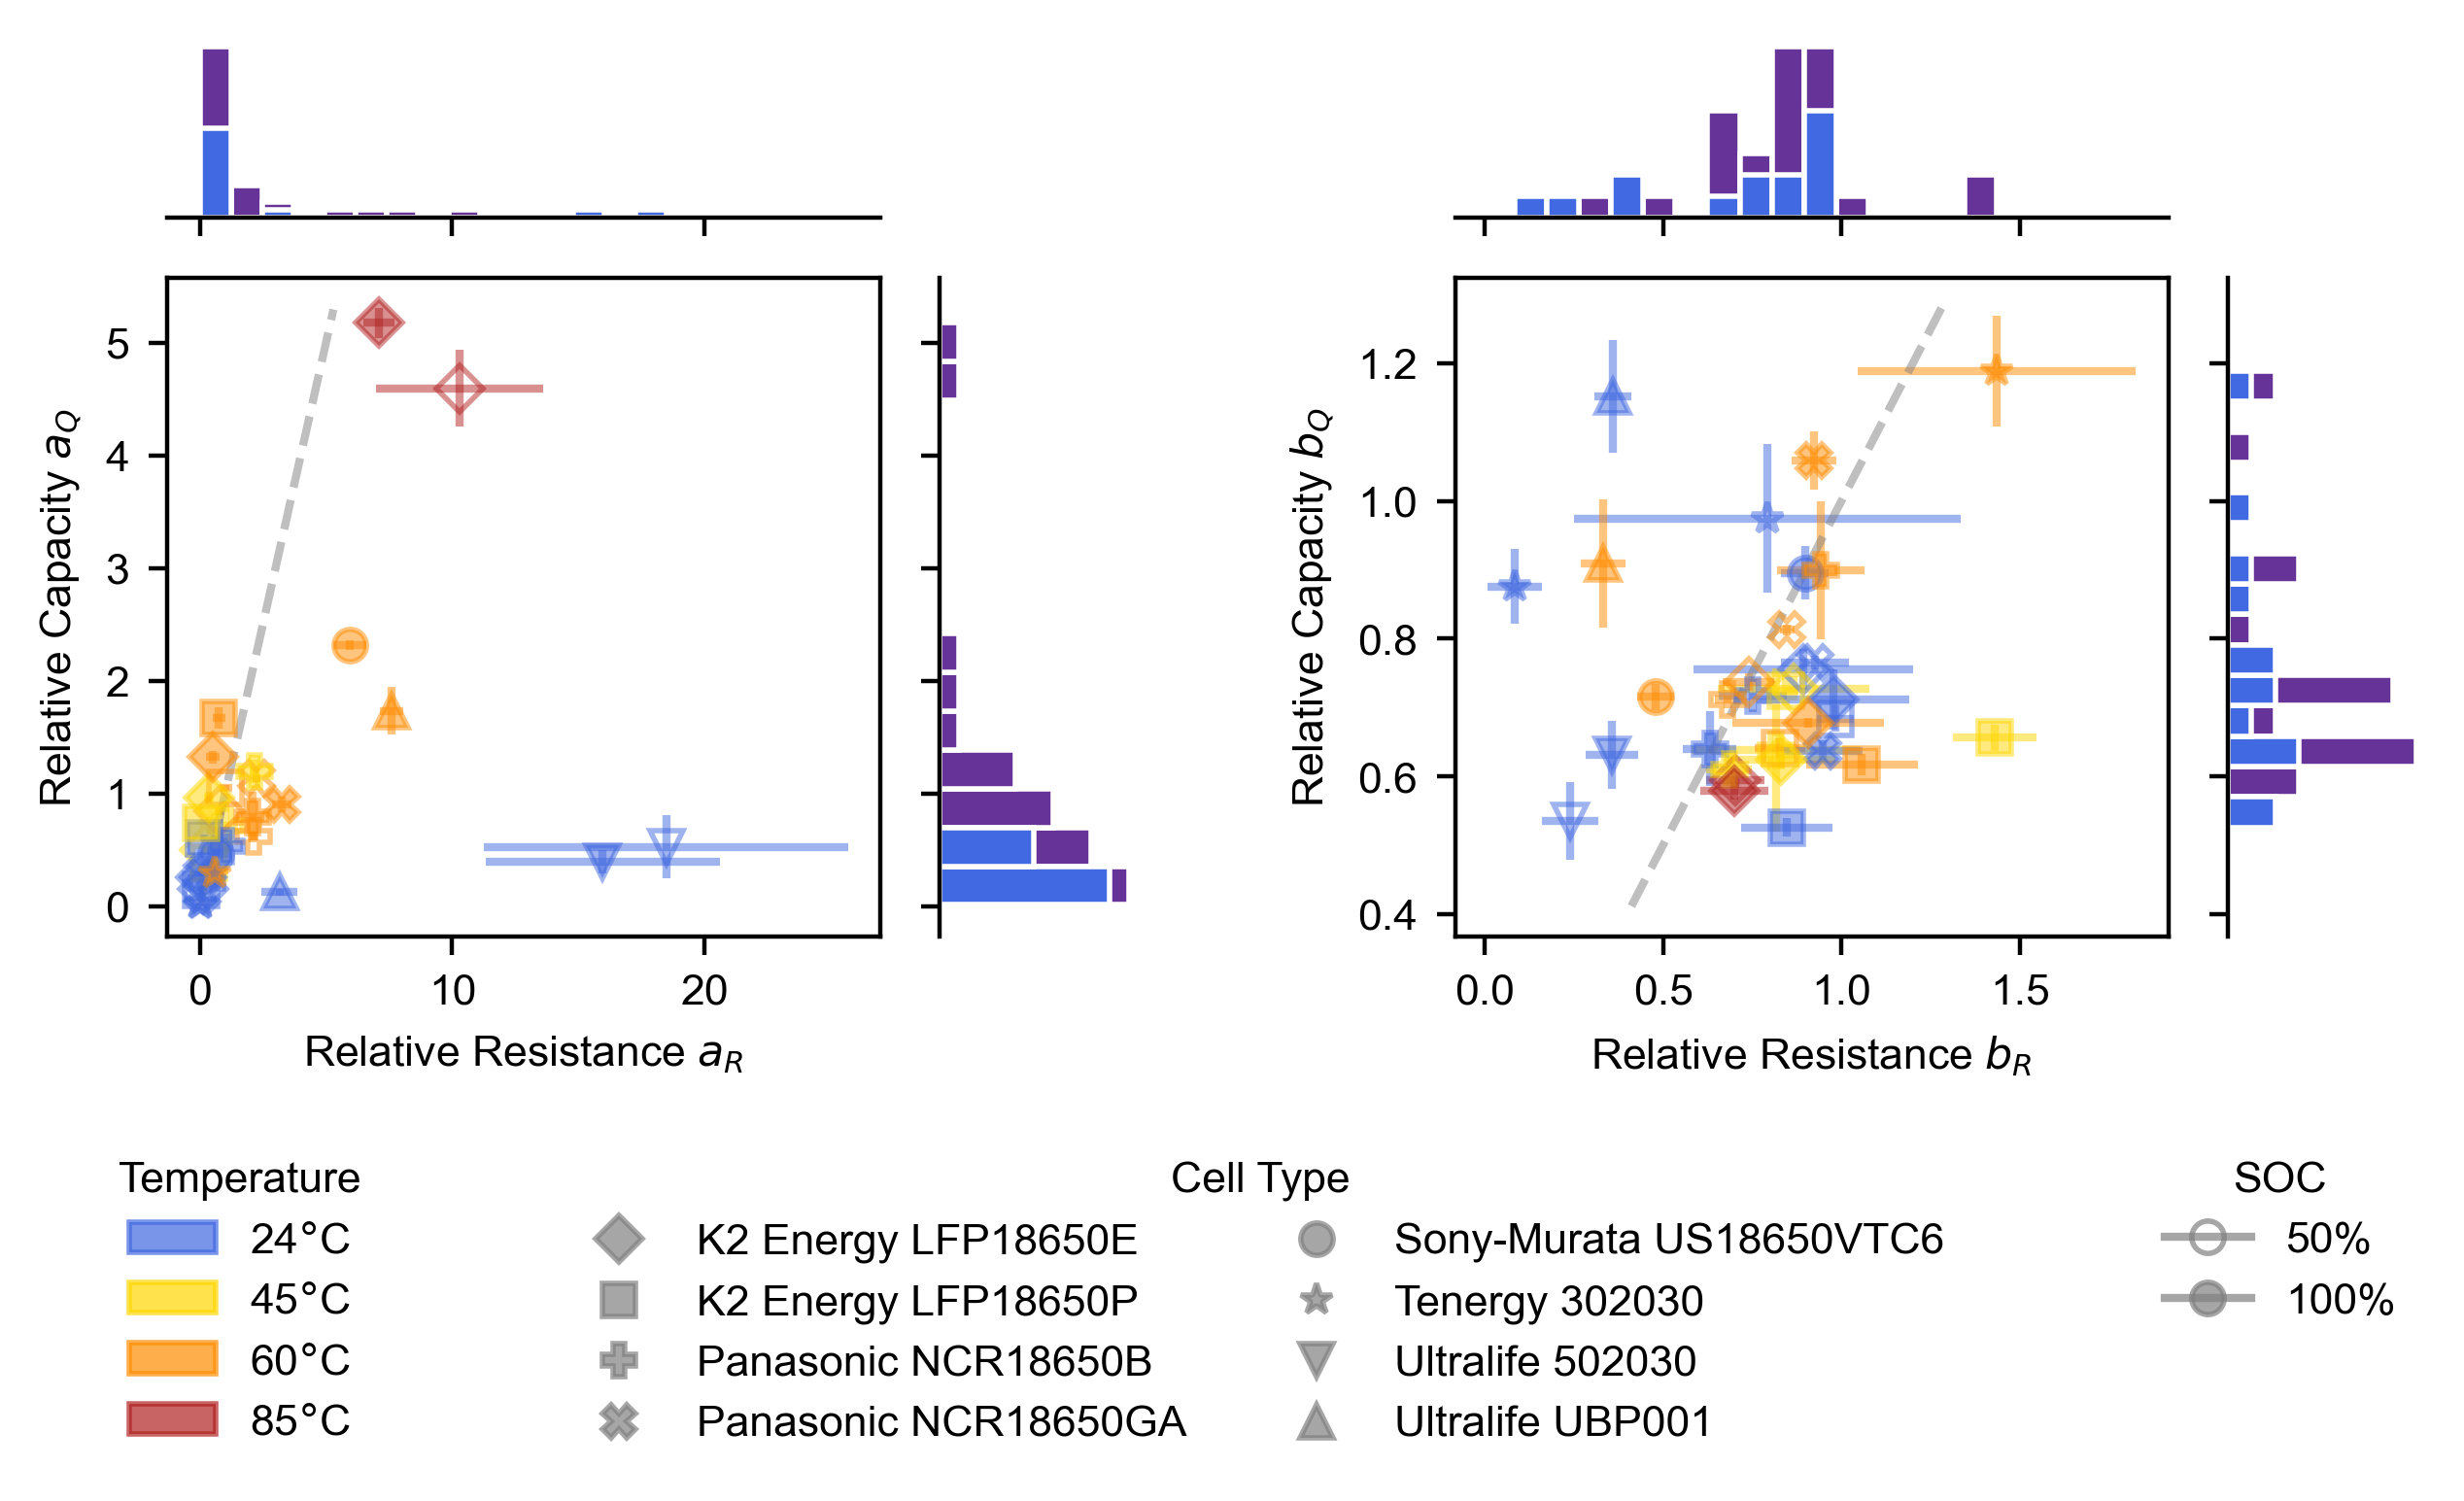

In [17]:
#Scatter plot with histogram

# Figure setup 
from matplotlib import gridspec

#Set up number of figures
axs = [None]*6
fig = plt.figure(figsize=(7.5,3.0), dpi = 400)
gs = gridspec.GridSpec(8, 9, hspace=1, wspace = 0.3)
#scatter 1
axs[0] = plt.subplot(gs[2:, :3])
#Top hist 1
axs[1] = plt.subplot(gs[:2, :3], sharex=axs[0])
#Side hist 1
axs[2] = plt.subplot(gs[2:, 3], sharey=axs[0])

#scatter 2
axs[3] = plt.subplot(gs[2:, 5:8])
#Top hist 2
axs[4] = plt.subplot(gs[:2, 5:8], sharex=axs[3])
#Side hist 2
axs[5] = plt.subplot(gs[2:, 8], sharey=axs[3])



ax = axs[0]
x_all = []
y_all = []
x_24C_all = []
y_24C_all = []
for soc in soc_list:
    temp_offset = 0
    for temp in temp_list:
        
        condition_list_cap = []
        std_list_cap = []
        condition_list_res = []
        std_list_cap_res = []
        for cell_type in cell_type_list[:]:
            marker_kwargs = {"marker": cell_type_marker_dict[cell_type], "fillstyle":soc_fill_dict[soc], 
            "color":temp_color_dict[temp], "alpha":0.5}

            condition_df_res = tx_resistance_df[(tx_resistance_df["Temperature"]==temp) & (tx_resistance_df["SOC"]==soc) & (tx_resistance_df["Cell_type"]==cell_type)]
            condition_df_cap = tx_cap_fitting_df[(tx_cap_fitting_df["Temperature"]==temp) & (tx_cap_fitting_df["SOC"]==soc) & (tx_cap_fitting_df["Cell_type"]==cell_type)]

            if len(condition_df_res)==0:
                continue
            else:
                x = np.mean(condition_df_res["a"])
                y = np.mean(condition_df_cap["a"])
                x_all.append(x)
                y_all.append(y)
                if temp==24:
                    x_24C_all.append(x)
                    y_24C_all.append(y)
                ax.errorbar(x, y, **marker_kwargs, yerr=np.std(condition_df_cap["a"]), 
                xerr=np.std(condition_df_res["a"]))


#Plot a 1to1 line
max_min = np.max([np.nanmin(tx_cap_fitting_df["a"]), np.nanmin(tx_resistance_df["a"])])
min_max = np.min([np.nanmax(tx_cap_fitting_df["a"]), np.nanmax(tx_resistance_df["a"])])
ax.plot([max_min, min_max], [max_min, min_max], color="gray", linestyle="--", alpha=0.5)

ax.set_xlabel("Relative Resistance " r"$a_R$")
ax.set_ylabel("Relative Capacity " r"$a_Q$")

#make histograms
x_range = (np.min(x_all), np.max(x_all))
y_range = (np.min(y_all), np.max(y_all))
axs[1].hist(x_all, bins=15, range=x_range, color='rebeccapurple', edgecolor="white")
axs[2].hist(y_all, bins=15, range=y_range, orientation='horizontal', color='rebeccapurple', edgecolor="white")
axs[1].hist(x_24C_all, bins=15, range=x_range, color='royalblue', edgecolor="white")
axs[2].hist(y_24C_all, bins=15, range=y_range, orientation='horizontal', color='royalblue', edgecolor="white")
#make cleaner (turn off shared axis label, and remove unused spines)
axs[1].tick_params(axis='x', labelbottom=False)
axs[1].tick_params(axis='y', labelleft=False)
axs[1].yaxis.set_ticks([])
axs[1].spines['left'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)


axs[2].tick_params(axis='y', labelleft=False)
axs[2].tick_params(axis='x', labelbottom=False)
axs[2].xaxis.set_ticks([])
axs[2].spines['bottom'].set_visible(False)
axs[2].spines['right'].set_visible(False)
axs[2].spines['top'].set_visible(False)

ax = axs[3]
x_all = []
y_all = []
x_24C_all = []
y_24C_all = []
for soc in soc_list:
    temp_offset = 0
    for temp in temp_list:
        
        condition_list_cap = []
        std_list_cap = []
        condition_list_res = []
        std_list_cap_res = []
        for cell_type in cell_type_list[:]:
            marker_kwargs = {"marker": cell_type_marker_dict[cell_type], "fillstyle":soc_fill_dict[soc], 
            "color":temp_color_dict[temp], "alpha":0.5}

            condition_df_res = tx_resistance_df[(tx_resistance_df["Temperature"]==temp) & (tx_resistance_df["SOC"]==soc) & (tx_resistance_df["Cell_type"]==cell_type)]
            condition_df_cap = tx_cap_fitting_df[(tx_cap_fitting_df["Temperature"]==temp) & (tx_cap_fitting_df["SOC"]==soc) & (tx_cap_fitting_df["Cell_type"]==cell_type)]

            if len(condition_df_res)==0:
                continue
            else:
                x = np.mean(condition_df_res["b"])
                y = np.mean(condition_df_cap["b"])
                x_all.append(x)
                y_all.append(y)
                if temp==24:
                    x_24C_all.append(x)
                    y_24C_all.append(y)
                ax.errorbar(x, y, **marker_kwargs, yerr=np.std(condition_df_cap["b"]), 
                xerr=np.std(condition_df_res["b"]))



#Plot a 1to1 line
max_min = np.max([np.nanmin(tx_cap_fitting_df["b"]), np.nanmin(tx_resistance_df["b"])])
min_max = np.min([np.nanmax(tx_cap_fitting_df["b"]), np.nanmax(tx_resistance_df["b"])])
ax.plot([max_min, min_max], [max_min, min_max], color="gray", linestyle="--", alpha=0.5)

# Create histograms on the sides of the scatter plot
x_range = (np.min(x_all), np.max(x_all))
y_range = (np.min(y_all), np.max(y_all))
axs[4].hist(x_all, bins=15, range=x_range, color='rebeccapurple', edgecolor="white")
axs[5].hist(y_all, bins=15, range=y_range, orientation='horizontal', color='rebeccapurple', edgecolor="white")
axs[4].hist(x_24C_all, bins=15, range=x_range, color='royalblue', edgecolor="white")
axs[5].hist(y_24C_all, bins=15, range=y_range, orientation='horizontal', color='royalblue', edgecolor="white")
#make cleaner (turn off shared axis label, and remove unused spines)
axs[4].tick_params(axis='x', labelbottom=False)
axs[4].tick_params(axis='y', labelleft=False)
axs[4].yaxis.set_ticks([])
axs[4].spines['left'].set_visible(False)
axs[4].spines['top'].set_visible(False)
axs[4].spines['right'].set_visible(False)

axs[5].tick_params(axis='y', labelleft=False)
axs[5].tick_params(axis='x', labelbottom=False)
axs[5].xaxis.set_ticks([])
axs[5].spines['bottom'].set_visible(False)
axs[5].spines['right'].set_visible(False)
axs[5].spines['top'].set_visible(False)


ax.set_xlabel("Relative Resistance " r"$b_R$")
ax.set_ylabel("Relative Capacity " r"$b_Q$")


### Adding in legend
legend_y = -0.05

cell_type_handles = []
for cell_type in cell_type_list:
    cell_type_handles.append(Line2D([0], [0],label='{}'.format(cell_type),color="gray", alpha=0.7, 
                    fillstyle="full",marker=cell_type_marker_dict[cell_type], linestyle="None"))

fig.legend(handles=cell_type_handles, loc="upper center",bbox_to_anchor=(0.5, legend_y), title="Cell Type", frameon=False, ncols=2)

patch_24 = mpatches.Patch(color='royalblue', label=r'24$\degree$C', alpha=0.7)
patch_45 = mpatches.Patch(color='gold', label=r'45$\degree$C', alpha=0.7)
patch_60 = mpatches.Patch(color='darkorange', label=r'60$\degree$C', alpha=0.7)
patch_85 = mpatches.Patch(color='firebrick', label=r'85$\degree$C', alpha=0.7)
temp_handles = [patch_24, patch_45, patch_60, patch_85]
fig.legend(handles=temp_handles, loc='upper center', ncol=1,bbox_to_anchor=(0.15, legend_y), title="Temperature", frameon=False)

line_soc_50 = Line2D([0], [0], label='50%', alpha=0.7, color="gray", marker="o", fillstyle="none")
line_soc_100 = Line2D([0], [0], label='100%', alpha=0.7, color="gray", marker="o", fillstyle="full")
soc_handles = [line_soc_50, line_soc_100]
fig.legend(handles=soc_handles, loc="upper center", ncol=1,bbox_to_anchor=(0.85, legend_y), title= "SOC", frameon=False)

#save fig
#fig.savefig("../figures/figure6_cap_vs_res_scatter.svg", format="svg", transparent=True, bbox_inches="tight")

plt.show()


## SI figures

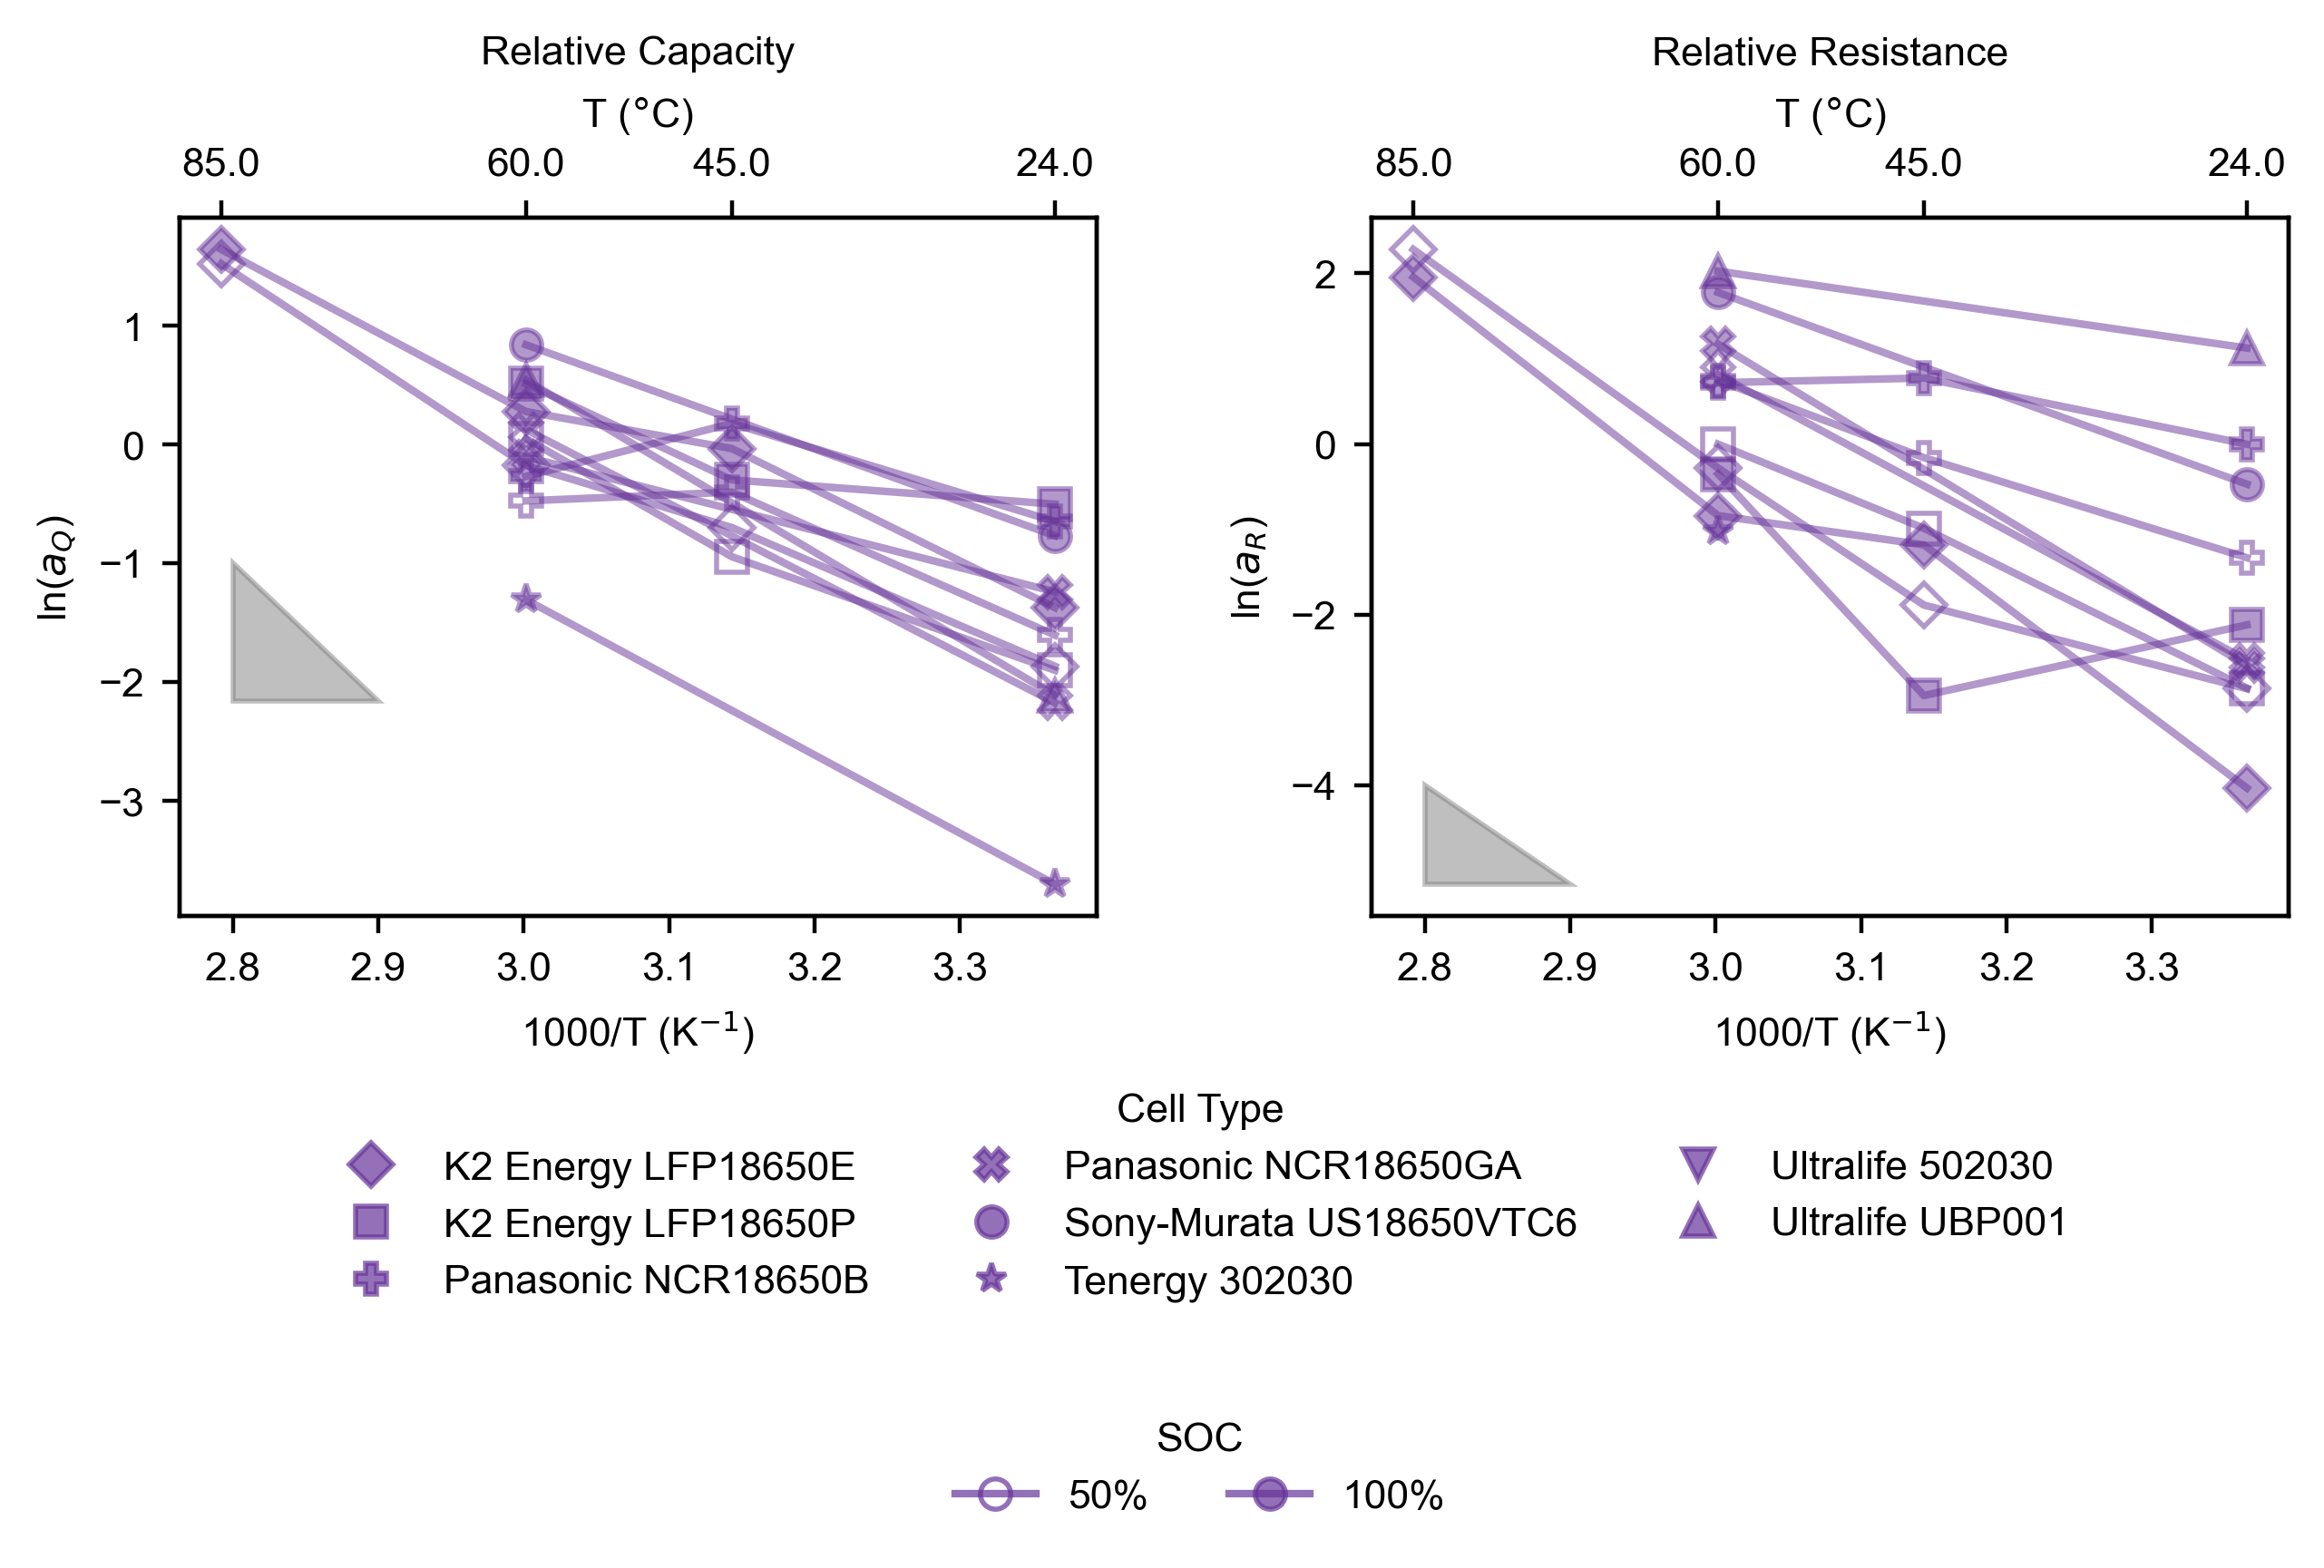

In [18]:
#Plot mean(ln(a)) vs 1/T for capacity and resistance


#This function to help transform axis between top and bottom
def inverse_T(x):
    return 1000/(x+273.15)

#Can change this to 2 to show cells with only 2 tested temperatures
min_temps = 2

fig, axs = plt.subplots(1,2, figsize=(7.5, 2.5), dpi=400)
ax=axs[0]
for cell_type in cell_type_list:
    cell_type_df = tx_cap_fitting_df[tx_cap_fitting_df["Cell_type"]==cell_type]
    for soc in set(cell_type_df["SOC"]):
        cell_type_set_soc_df = cell_type_df[cell_type_df["SOC"]==soc]
        mean_df = cell_type_set_soc_df.groupby("inverse_T(K)")["log_a"].mean().reset_index()
        if len(mean_df) < min_temps:
            continue
        marker_kwargs = {"marker": cell_type_marker_dict[cell_type], "fillstyle":soc_fill_dict[soc], 
                    "color":"rebeccapurple", "alpha":0.5}
        ax.plot(mean_df["inverse_T(K)"]*1000,mean_df["log_a"], **marker_kwargs)

ax.set_title("Relative Capacity")
ax.set_xlabel(r"1000/T (K$^{-1}$)")
ax.set_ylabel(r"ln($a_Q$)")


#Plotting 1eV slope
ev = 1
ev_slope = -1*ev/KB_EV
start_y = -1
start_x = 0.0028
delta = 0.0001
x = np.array([start_x, start_x, start_x+delta])*1000 #1000 to make it 1000/T
y = [start_y, start_y+ev_slope*delta, start_y+ev_slope*delta]
ax.fill(x, y, color="gray", alpha=0.5)

#This is for adding top label
ax_twin = ax.twiny()
ax_twin.set_xlim(ax.get_xlim())
ax_twin.set_xlabel(r"T ($\degree$C)")

x_ticks = np.array([24, 45, 60, 85])  # Define the desired tick positions
ax_twin.set_xticks(inverse_T(x_ticks))  # Convert tick positions using the forward transformation
ax_twin.set_xticklabels([f'{tick:.1f}' for tick in x_ticks])  # Set tick labels


ax=axs[1]
for cell_type in cell_type_list:
    cell_type_df = tx_resistance_df[tx_resistance_df["Cell_type"]==cell_type]
    for soc in set(cell_type_df["SOC"]):
        cell_type_set_soc_df = cell_type_df[cell_type_df["SOC"]==soc]
        mean_df = cell_type_set_soc_df.groupby("inverse_T(K)")["log_a"].mean().reset_index()
        if len(mean_df) < min_temps:
            continue
        marker_kwargs = {"marker": cell_type_marker_dict[cell_type], "fillstyle":soc_fill_dict[soc], 
                    "color":"rebeccapurple", "alpha":0.5}
        ax.plot(mean_df["inverse_T(K)"]*1000,mean_df["log_a"], **marker_kwargs)


ax.set_title("Relative Resistance")
ax.set_xlabel(r"1000/T (K$^{-1}$)")
ax.set_ylabel(r"ln($a_R$)")

#Plotting 1eV slope
ev = 1
ev_slope = -1*ev/KB_EV
start_y = -4
start_x = 0.0028
delta = 0.0001
x = np.array([start_x, start_x, start_x+delta])*1000 #1000 to make it 1000/T
y = [start_y, start_y+ev_slope*delta, start_y+ev_slope*delta]
ax.fill(x, y, color="gray", alpha=0.5)

#This is for adding top label
ax_twin = ax.twiny()

ax_twin.set_xlim(ax.get_xlim())
ax_twin.set_xlabel(r"T ($\degree$C)")

x_ticks = np.array([24, 45, 60, 85])  # Define the desired tick positions
ax_twin.set_xticks(inverse_T(x_ticks))  # Convert tick positions using the forward transformation
ax_twin.set_xticklabels([f'{tick:.1f}' for tick in x_ticks])  # Set tick labels

plt.subplots_adjust(wspace=0.3)

### Add legend
color = "rebeccapurple"
cell_type_handles =[]
for cell_type in cell_type_list:
    cell_type_handles.append(Line2D([0], [0],label='{}'.format(cell_type),color=color, alpha=0.7, 
                    fillstyle="full",marker=cell_type_marker_dict[cell_type], linestyle="None"))

fig.legend(handles=cell_type_handles,bbox_to_anchor=(0.5, -0.2), loc="center", title="Cell Type", frameon=False, ncols=3)

line_soc_50 = Line2D([0], [0], label='50%', alpha=0.7, color=color, marker="o", fillstyle="none")
line_soc_100 = Line2D([0], [0], label='100%', alpha=0.7, color=color, marker="o", fillstyle="full")
soc_handles = [line_soc_50, line_soc_100]
fig.legend(handles=soc_handles, bbox_to_anchor=(0.5, -0.5), loc="center", ncol=2, title= "SOC", frameon=False)

#fig.savefig("../figures/SI_figure_ArrheniusPlot_aQ_aR_2temp.svg", format="svg", transparent=True, bbox_inches="tight")
plt.show()


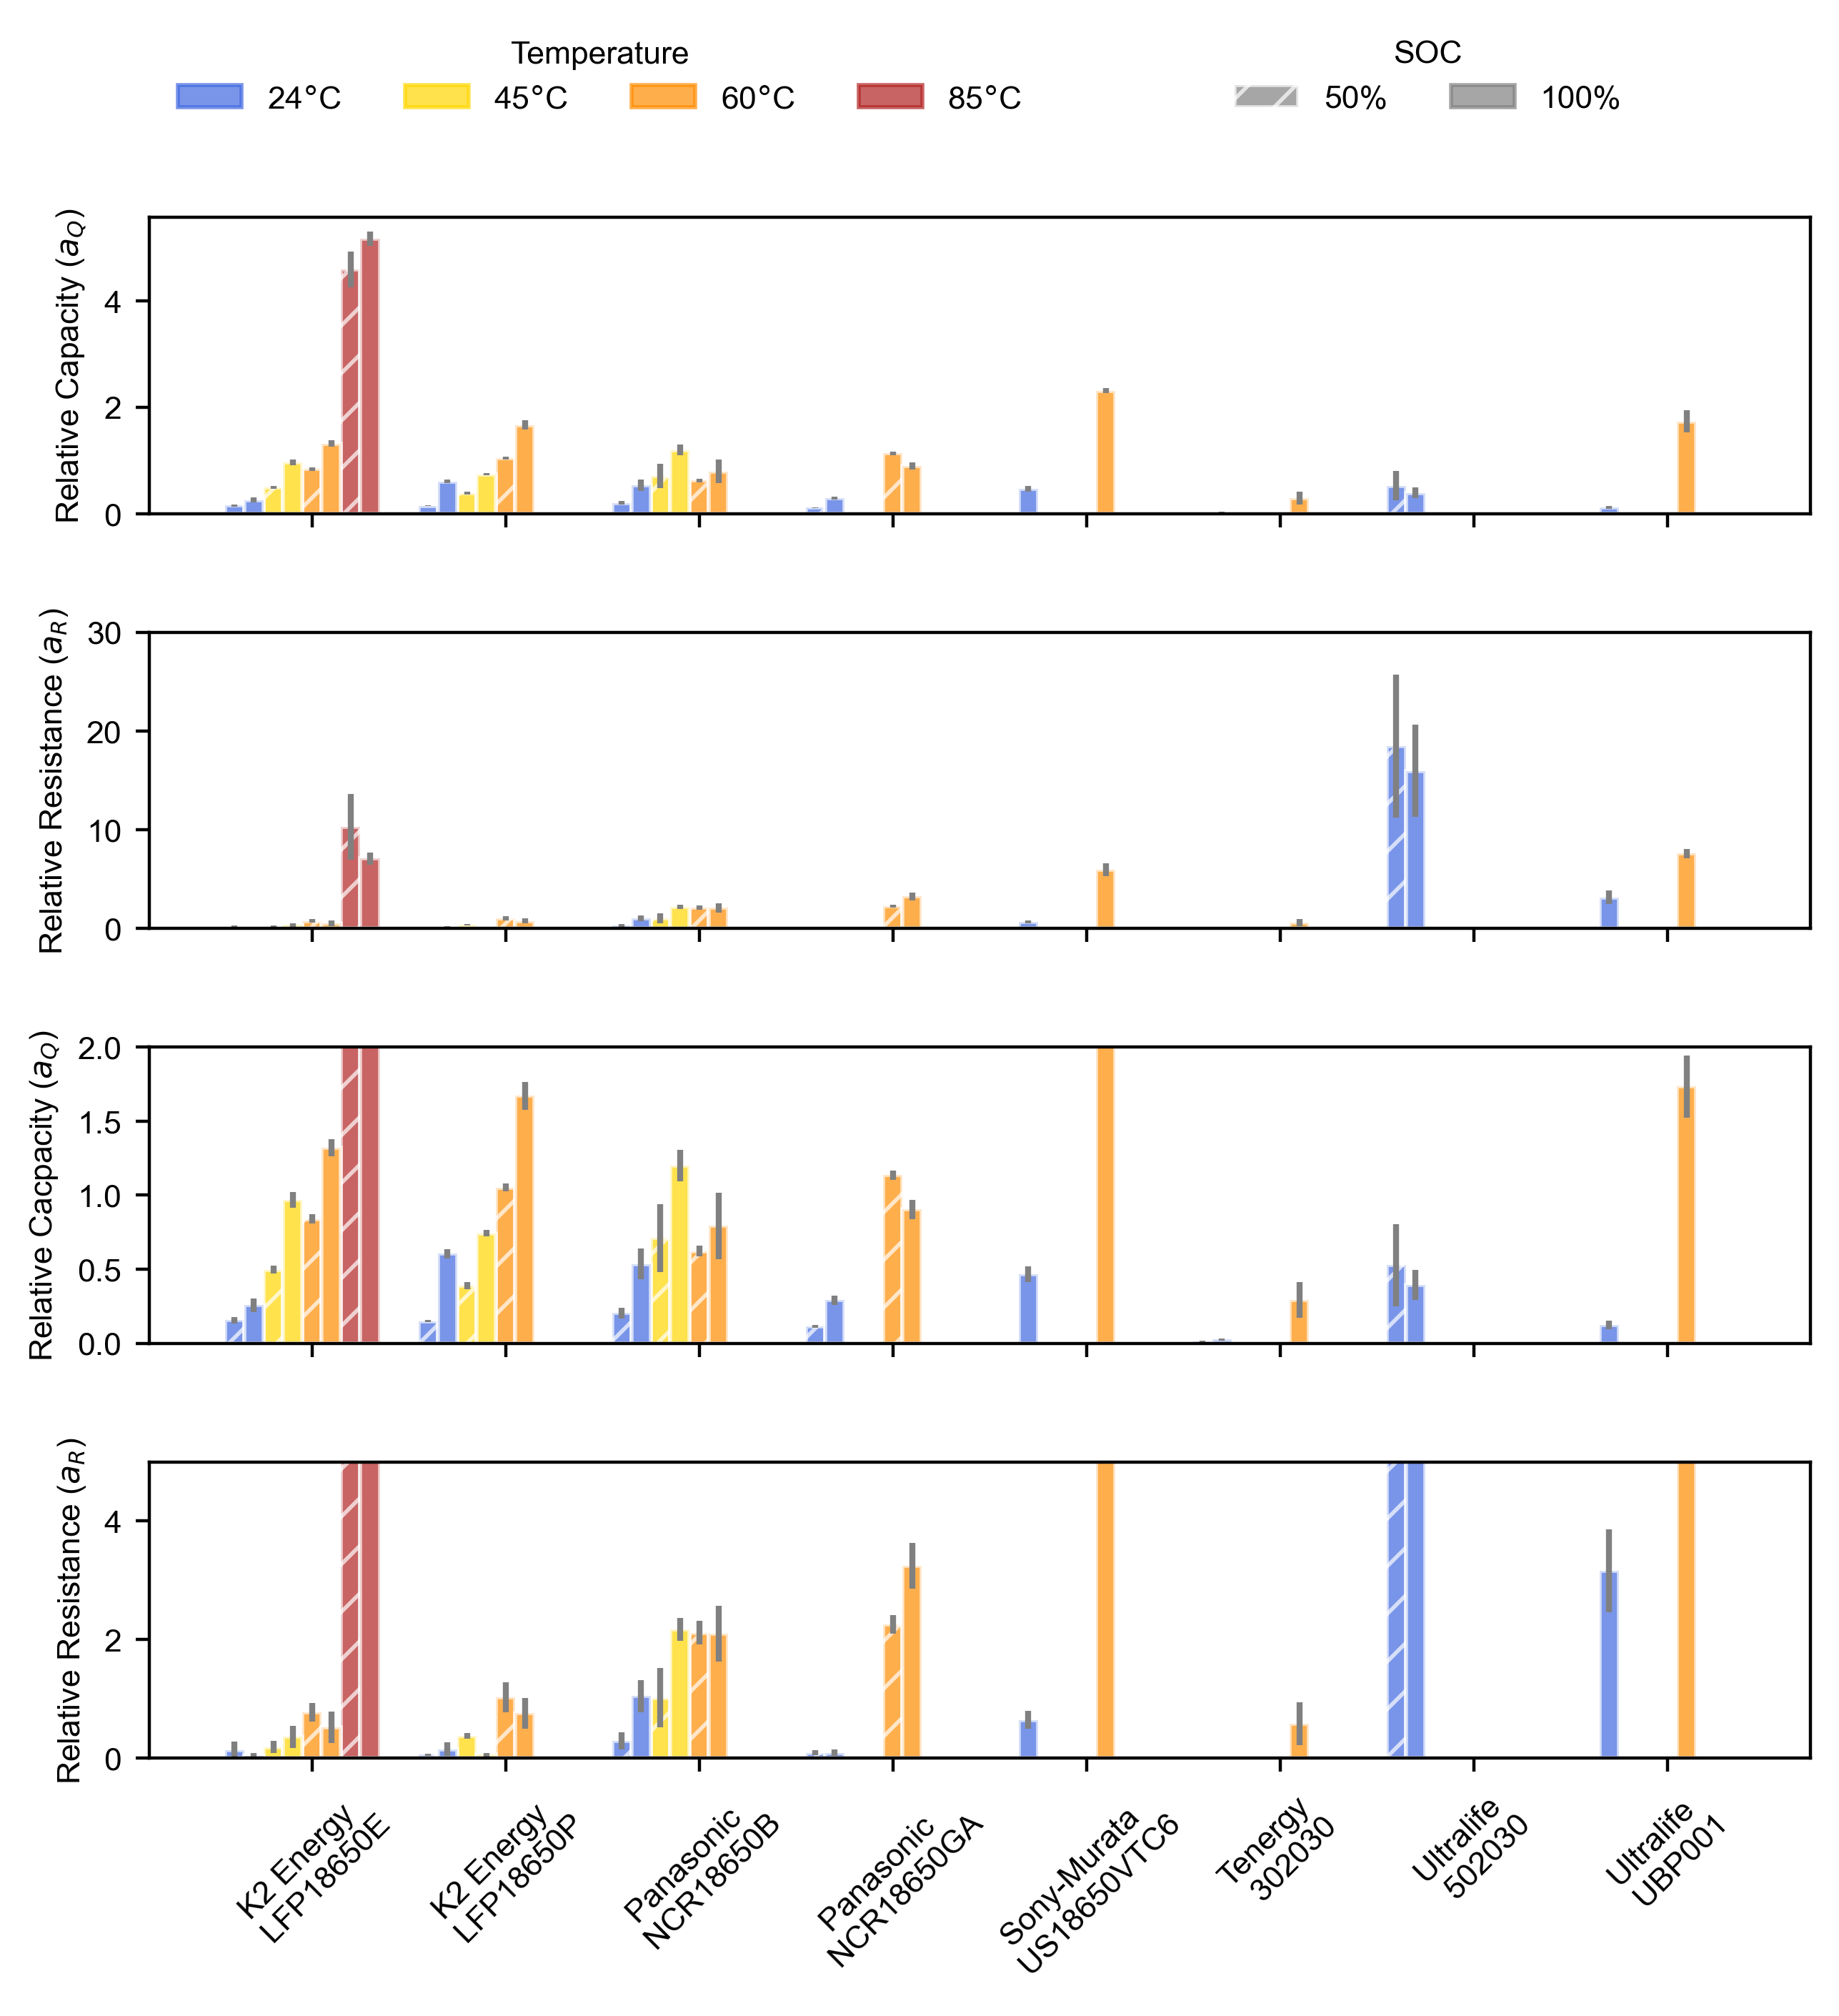

In [19]:
## SI plot on a values of capacity and resistance

# Plotting all the a preexponent coeff for all conditions
fig, axs = plt.subplots(4, 1, figsize=(7.5,7), dpi=400)

temp_list = [24, 45, 60, 85]
soc_list = [50, 100]
soc_hatch_style = ["//", ""]


x = np.arange(len(cell_type_list))*10*width

color_list = ["royalblue", "gold", "darkorange", "firebrick"]

width=0.25
idx = 0
soc_offset=0
for soc in soc_list:
    temp_offset = 0
    for temp in temp_list:
        
        condition_list = []
        std_list = []
        for cell_type in cell_type_list[:]:

            condition_df = tx_cap_fitting_df[(tx_cap_fitting_df["Temperature"]==temp) & (tx_cap_fitting_df["SOC"]==soc) & (tx_cap_fitting_df["Cell_type"]==cell_type)]

            if len(condition_df)==0:
                condition_list.append(0)
                std_list.append(0)
            else:
                condition_list.append(np.mean(condition_df["a"]))
                std_list.append(np.std(condition_df["a"]))


        offset = width*2 * temp_offset + soc_offset*width
        rects = axs[0].bar(x + offset, condition_list, width,edgecolor="white",alpha=0.7, color=color_list[temp_list.index(temp)], 
                    hatch=soc_hatch_style[soc_list.index(soc)], yerr=std_list, ecolor="grey", label="T={}C, SOC={}%".format(temp, soc))
        rects = axs[2].bar(x + offset, condition_list, width,edgecolor="white",alpha=0.7, color=color_list[temp_list.index(temp)], 
                    hatch=soc_hatch_style[soc_list.index(soc)], yerr=std_list, ecolor="grey", label="T={}C, SOC={}%".format(temp, soc))

        temp_offset += 1
        idx+=1

    soc_offset+=1


axs[0].set_xticks(x + 4*width, []*len(x))
axs[0].set_ylabel(r"Relative Capacity ($a_Q$)")

axs[2].set_xticks(x + 4*width, []*len(x))
axs[2].set_ylabel(r"Relative Cacpacity ($a_Q$)")
axs[2].set_ylim([0,2])


###Adding in for Resistance

width=0.25
idx = 0
soc_offset=0
for soc in soc_list:
    temp_offset = 0
    for temp in temp_list:
        
        condition_list = []
        std_list = []
        for cell_type in cell_type_list[:]:

            condition_df = tx_resistance_df[(tx_resistance_df["Temperature"]==temp) & (tx_resistance_df["SOC"]==soc) & (tx_resistance_df["Cell_type"]==cell_type)]

            if len(condition_df)==0:
                condition_list.append(0)
                std_list.append(0)
            else:
                condition_list.append(np.mean(condition_df["a"]))
                std_list.append(np.std(condition_df["a"]))


        offset = width*2 * temp_offset + soc_offset*width
        rects = axs[1].bar(x + offset, condition_list, width,edgecolor="white",alpha=0.7, color=color_list[temp_list.index(temp)], 
                    hatch=soc_hatch_style[soc_list.index(soc)], yerr=std_list, ecolor="grey", label="T={}C, SOC={}%".format(temp, soc))
        rects = axs[3].bar(x + offset, condition_list, width,edgecolor="white",alpha=0.7, color=color_list[temp_list.index(temp)], 
                    hatch=soc_hatch_style[soc_list.index(soc)], yerr=std_list, ecolor="grey", label="T={}C, SOC={}%".format(temp, soc))
        temp_offset += 1
        idx+=1

    soc_offset+=1

new_label_list = []
for old_label in cell_type_list:

    if old_label.split(" ")[0] =="K2":
        new_label = old_label.split(" ")[0]+ " " +old_label.split(" ")[1] + " \n " + old_label.split(" ")[2]

    else:
        new_label = old_label.split(" ")[0] + " \n " + old_label.split(" ")[1]

    new_label_list.append(new_label)

axs[1].set_xticks(x + 4*width, []*len(x))
axs[3].set_xticks(x + 4*width, new_label_list, rotation=45)
axs[1].set_ylabel(r"Relative Resistance ($a_R$)")
axs[3].set_ylabel(r"Relative Resistance ($a_R$)")

axs[1].set_ylim([0,30])
axs[3].set_ylim([0,5])


plt.subplots_adjust(hspace=0.4)

patch_24 = mpatches.Patch(color='royalblue', label=r'24$\degree$C', alpha=0.7)
patch_45 = mpatches.Patch(color='gold', label=r'45$\degree$C', alpha=0.7)
patch_60 = mpatches.Patch(color='darkorange', label=r'60$\degree$C', alpha=0.7)
patch_85 = mpatches.Patch(color='firebrick', label=r'85$\degree$C', alpha=0.7)


temp_handles = [patch_24, patch_45, patch_60, patch_85]


patch_soc_50 = mpatches.Patch(facecolor = "gray", edgecolor='white', label='50%', hatch="//", alpha=0.7)
patch_soc_100 = mpatches.Patch(color='gray', label='100%', hatch="", alpha=0.7)

soc_handles = [patch_soc_50, patch_soc_100]

fig.legend(handles=temp_handles, loc='center left', ncol=4, title="Temperature",bbox_to_anchor=(0.125, 0.95), frameon=False)
fig.legend(handles=soc_handles, ncol=2, loc="center right",bbox_to_anchor=(0.825, 0.95), title= "SOC", frameon=False)

#save fig
#fig.savefig("../figures/SI_figure_aQ_aR_bar_plot.svg", format="svg", transparent=True, bbox_inches="tight")
plt.show()


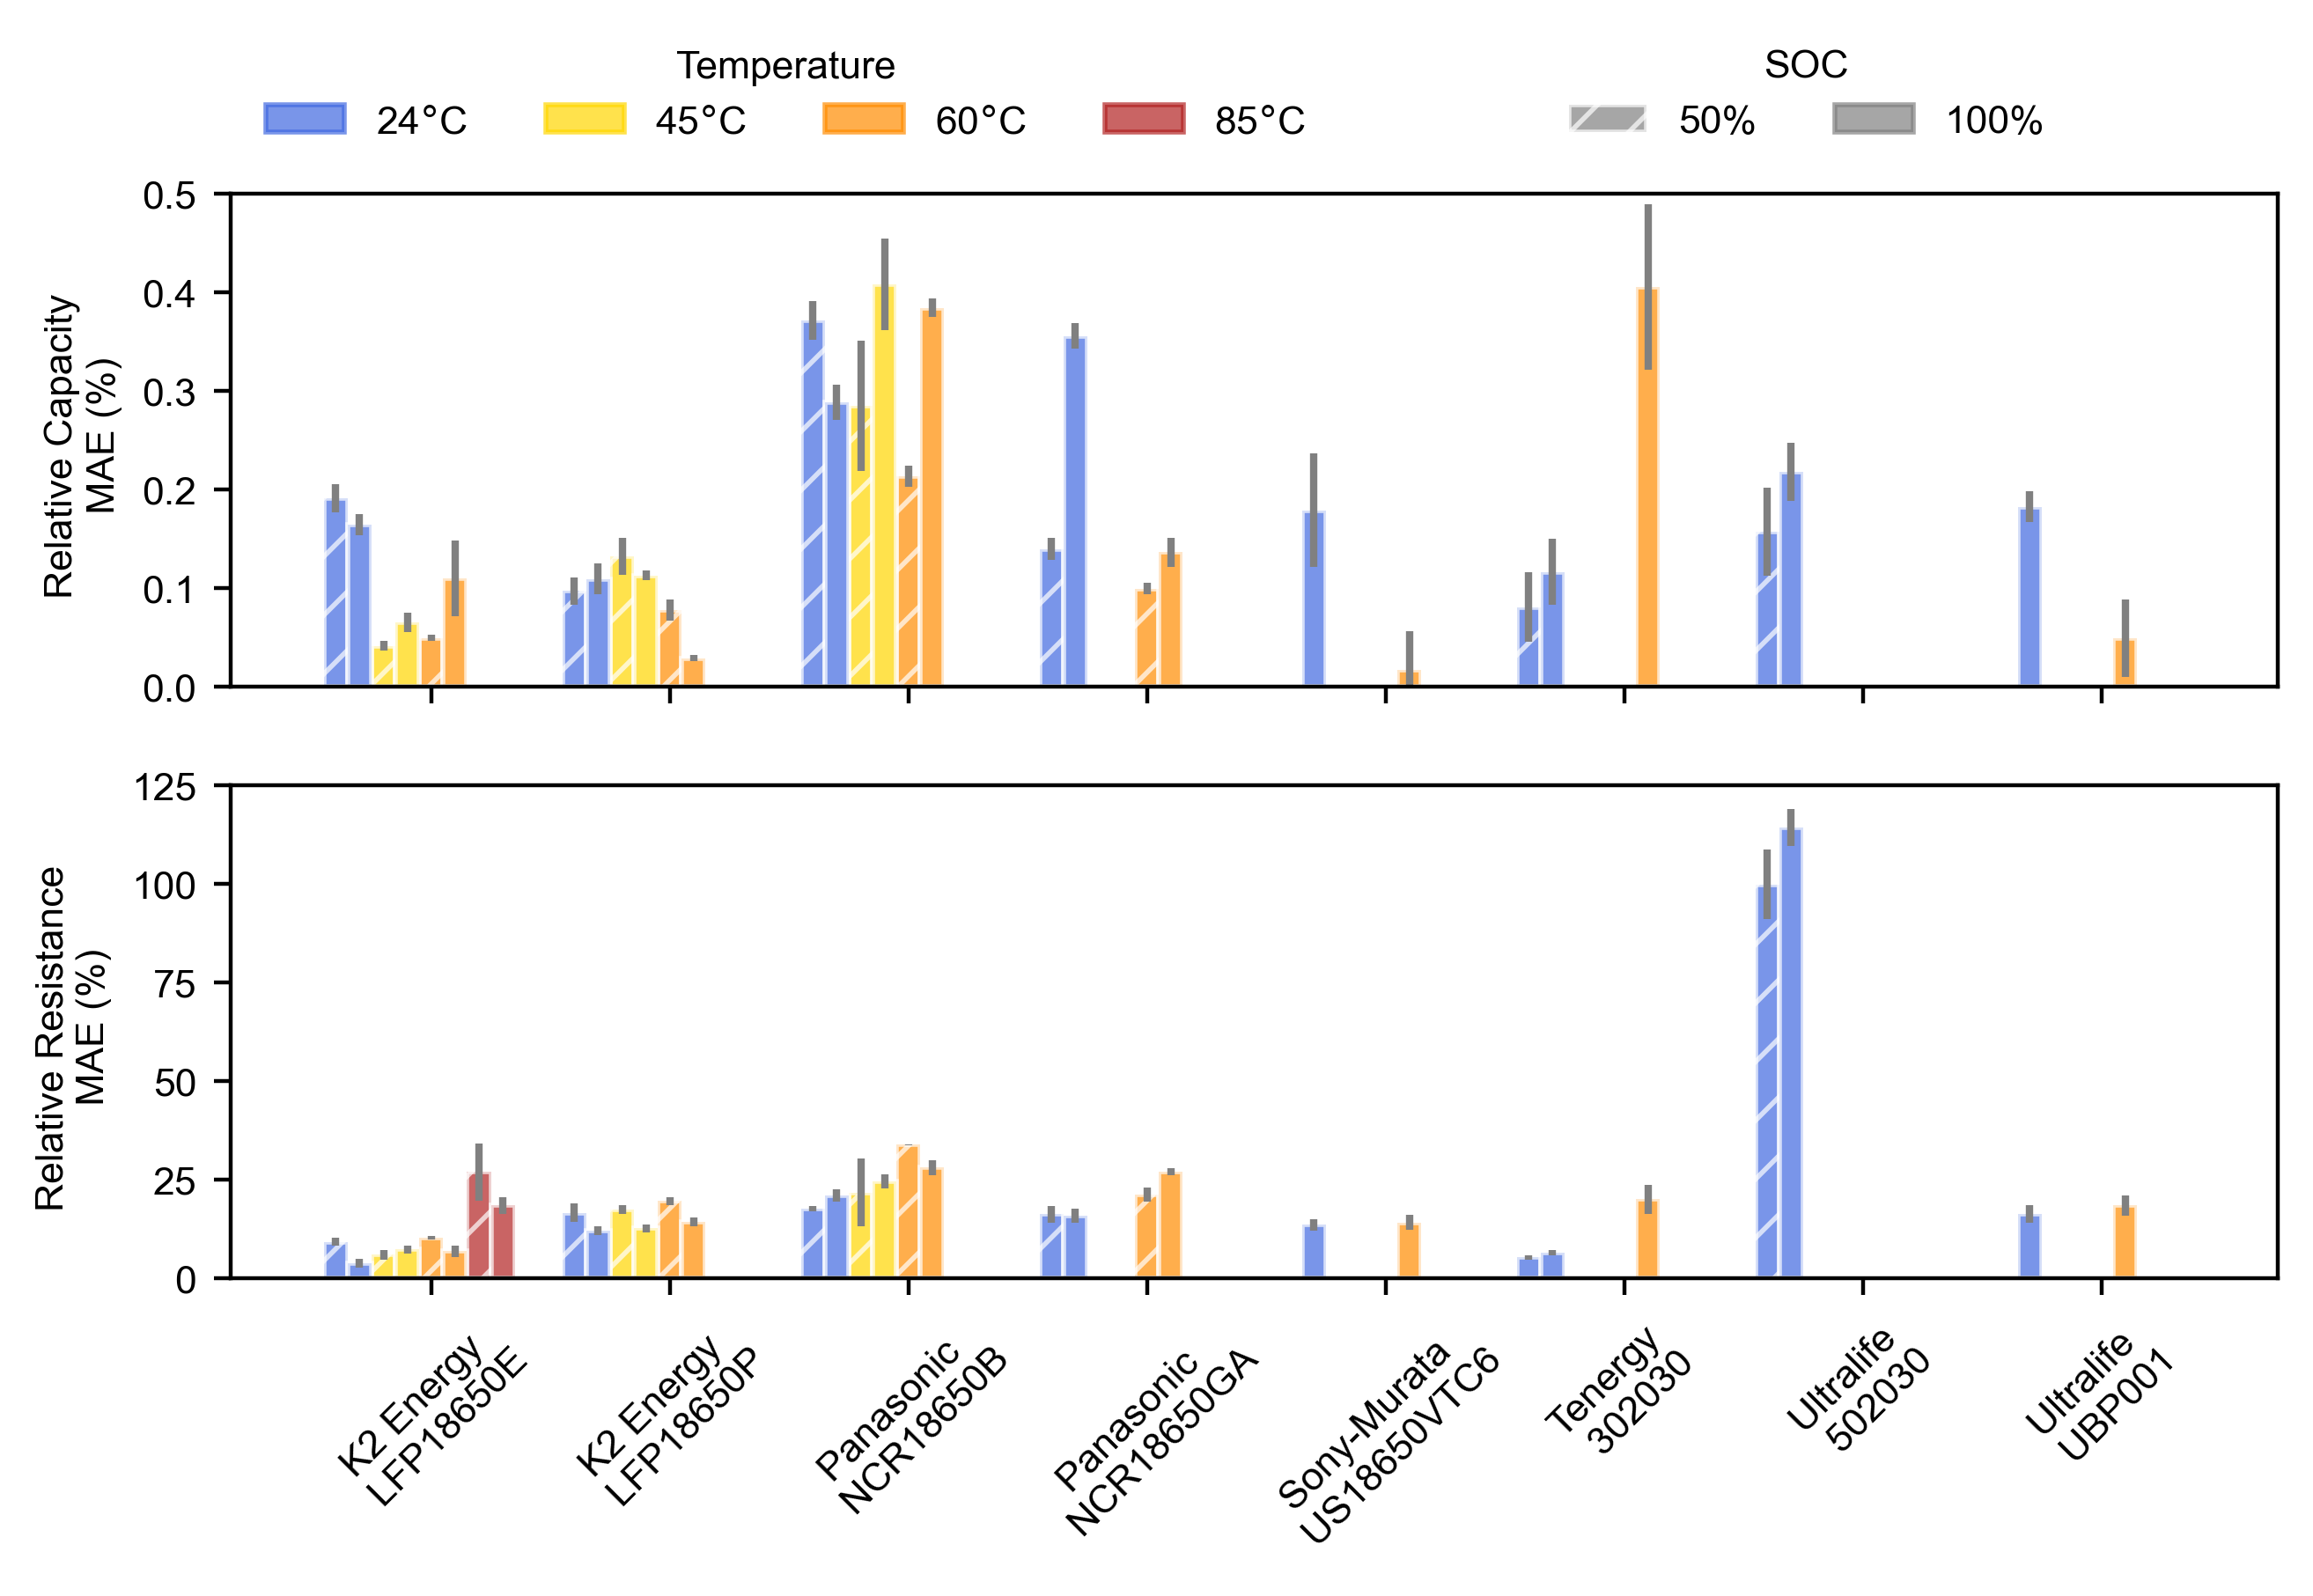

In [20]:

# Plotting all the mae for all conditions
fig, axs = plt.subplots(2, 1, figsize=(7.5,4), dpi=400)

temp_list = [24, 45, 60, 85]
soc_list = [50, 100]
soc_hatch_style = ["//", ""]

x = np.arange(len(cell_type_list))*10*width

color_list = ["royalblue", "gold", "darkorange", "firebrick"]

ax = axs[0]
width=0.25
idx = 0
soc_offset=0
for soc in soc_list:
    temp_offset = 0
    for temp in temp_list:
        
        condition_list = []
        std_list = []
        for cell_type in cell_type_list[:]:

            condition_df = tx_cap_fitting_df[(tx_cap_fitting_df["Temperature"]==temp) & (tx_cap_fitting_df["SOC"]==soc) & (tx_cap_fitting_df["Cell_type"]==cell_type)]

            if len(condition_df)==0:
                condition_list.append(0)
                std_list.append(0)
            else:
                condition_list.append(np.mean(condition_df["mae"]))
                std_list.append(np.std(condition_df["mae"]))
                


        offset = width*2 * temp_offset + soc_offset*width
        rects = ax.bar(x + offset, condition_list, width,edgecolor="white",alpha=0.7, color=color_list[temp_list.index(temp)], 
        hatch=soc_hatch_style[soc_list.index(soc)], yerr=std_list, ecolor="grey", label="T={}C, SOC={}%".format(temp, soc))

        temp_offset += 1
        idx+=1

    soc_offset+=1

ax.set_xticks(x + 4*width, []*len(x))
ax.set_ylabel("Relative Capacity \n MAE (%)")
ax.set_ylim([0, 0.5])


###Adding in for Resistance

ax = axs[1]
width=0.25
idx = 0
soc_offset=0
for soc in soc_list:
    temp_offset = 0
    for temp in temp_list:
        
        condition_list = []
        std_list = []
        for cell_type in cell_type_list[:]:

            condition_df = tx_resistance_df[(tx_resistance_df["Temperature"]==temp) & (tx_resistance_df["SOC"]==soc) & (tx_resistance_df["Cell_type"]==cell_type)]

            if len(condition_df)==0:
                condition_list.append(0)
                std_list.append(0)
            else:
                condition_list.append(np.mean(condition_df["mae"]))
                std_list.append(np.std(condition_df["mae"]))


        offset = width*2 * temp_offset + soc_offset*width
        rects = ax.bar(x + offset, condition_list, width,edgecolor="white",alpha=0.7, color=color_list[temp_list.index(temp)], 
        hatch=soc_hatch_style[soc_list.index(soc)], yerr=std_list, ecolor="grey", label="T={}C, SOC={}%".format(temp, soc))

        temp_offset += 1
        idx+=1

    soc_offset+=1

new_label_list = []
for old_label in cell_type_list:

    if old_label.split(" ")[0] =="K2":
        new_label = old_label.split(" ")[0]+ " " +old_label.split(" ")[1] + " \n " + old_label.split(" ")[2]

    else:
        new_label = old_label.split(" ")[0] + " \n " + old_label.split(" ")[1]

    new_label_list.append(new_label)


ax.set_xticks(x + 4*width, new_label_list, rotation=45)
ax.set_ylabel("Relative Resistance \n MAE (%)")
ax.set_ylim([0, 125])

patch_24 = mpatches.Patch(color='royalblue', label=r'24$\degree$C', alpha=0.7)
patch_45 = mpatches.Patch(color='gold', label=r'45$\degree$C', alpha=0.7)
patch_60 = mpatches.Patch(color='darkorange', label=r'60$\degree$C', alpha=0.7)
patch_85 = mpatches.Patch(color='firebrick', label=r'85$\degree$C', alpha=0.7)


temp_handles = [patch_24, patch_45, patch_60, patch_85]


patch_soc_50 = mpatches.Patch(facecolor = "gray", edgecolor='white', label='50%', hatch="//", alpha=0.7)
patch_soc_100 = mpatches.Patch(color='gray', label='100%', hatch="", alpha=0.7)

soc_handles = [patch_soc_50, patch_soc_100]

fig.legend(handles=temp_handles, loc='center left', ncol=4, title="Temperature",bbox_to_anchor=(0.125, 0.95), frameon=False)
fig.legend(handles=soc_handles, ncol=2, loc="center right",bbox_to_anchor=(0.825, 0.95), title= "SOC", frameon=False)


#fig.savefig("../figures/SI_figure_mae_barplot.svg", format="svg", transparent=True, bbox_inches="tight")
plt.show()




In [21]:
#prepare df for easy handling
merged_cap_res_df = tx_resistance_df.merge(tx_cap_fitting_df, on="filename", suffixes=('_R', '_Q'))
columns_to_drop = ["Temperature_R", "SOC_R", "Cell_type_R", "Chemistry_R"]
rename_col_dict = {"Temperature_Q": "Temperature", "Cell_type_Q": "Cell_type", "SOC_Q": "SOC", "Chemistry_Q": "Chemistry"}
merged_cap_res_df = merged_cap_res_df.drop(columns=columns_to_drop)
merged_cap_res_df = merged_cap_res_df.rename(columns=rename_col_dict)

Text(0.5, 0, 'a_R')

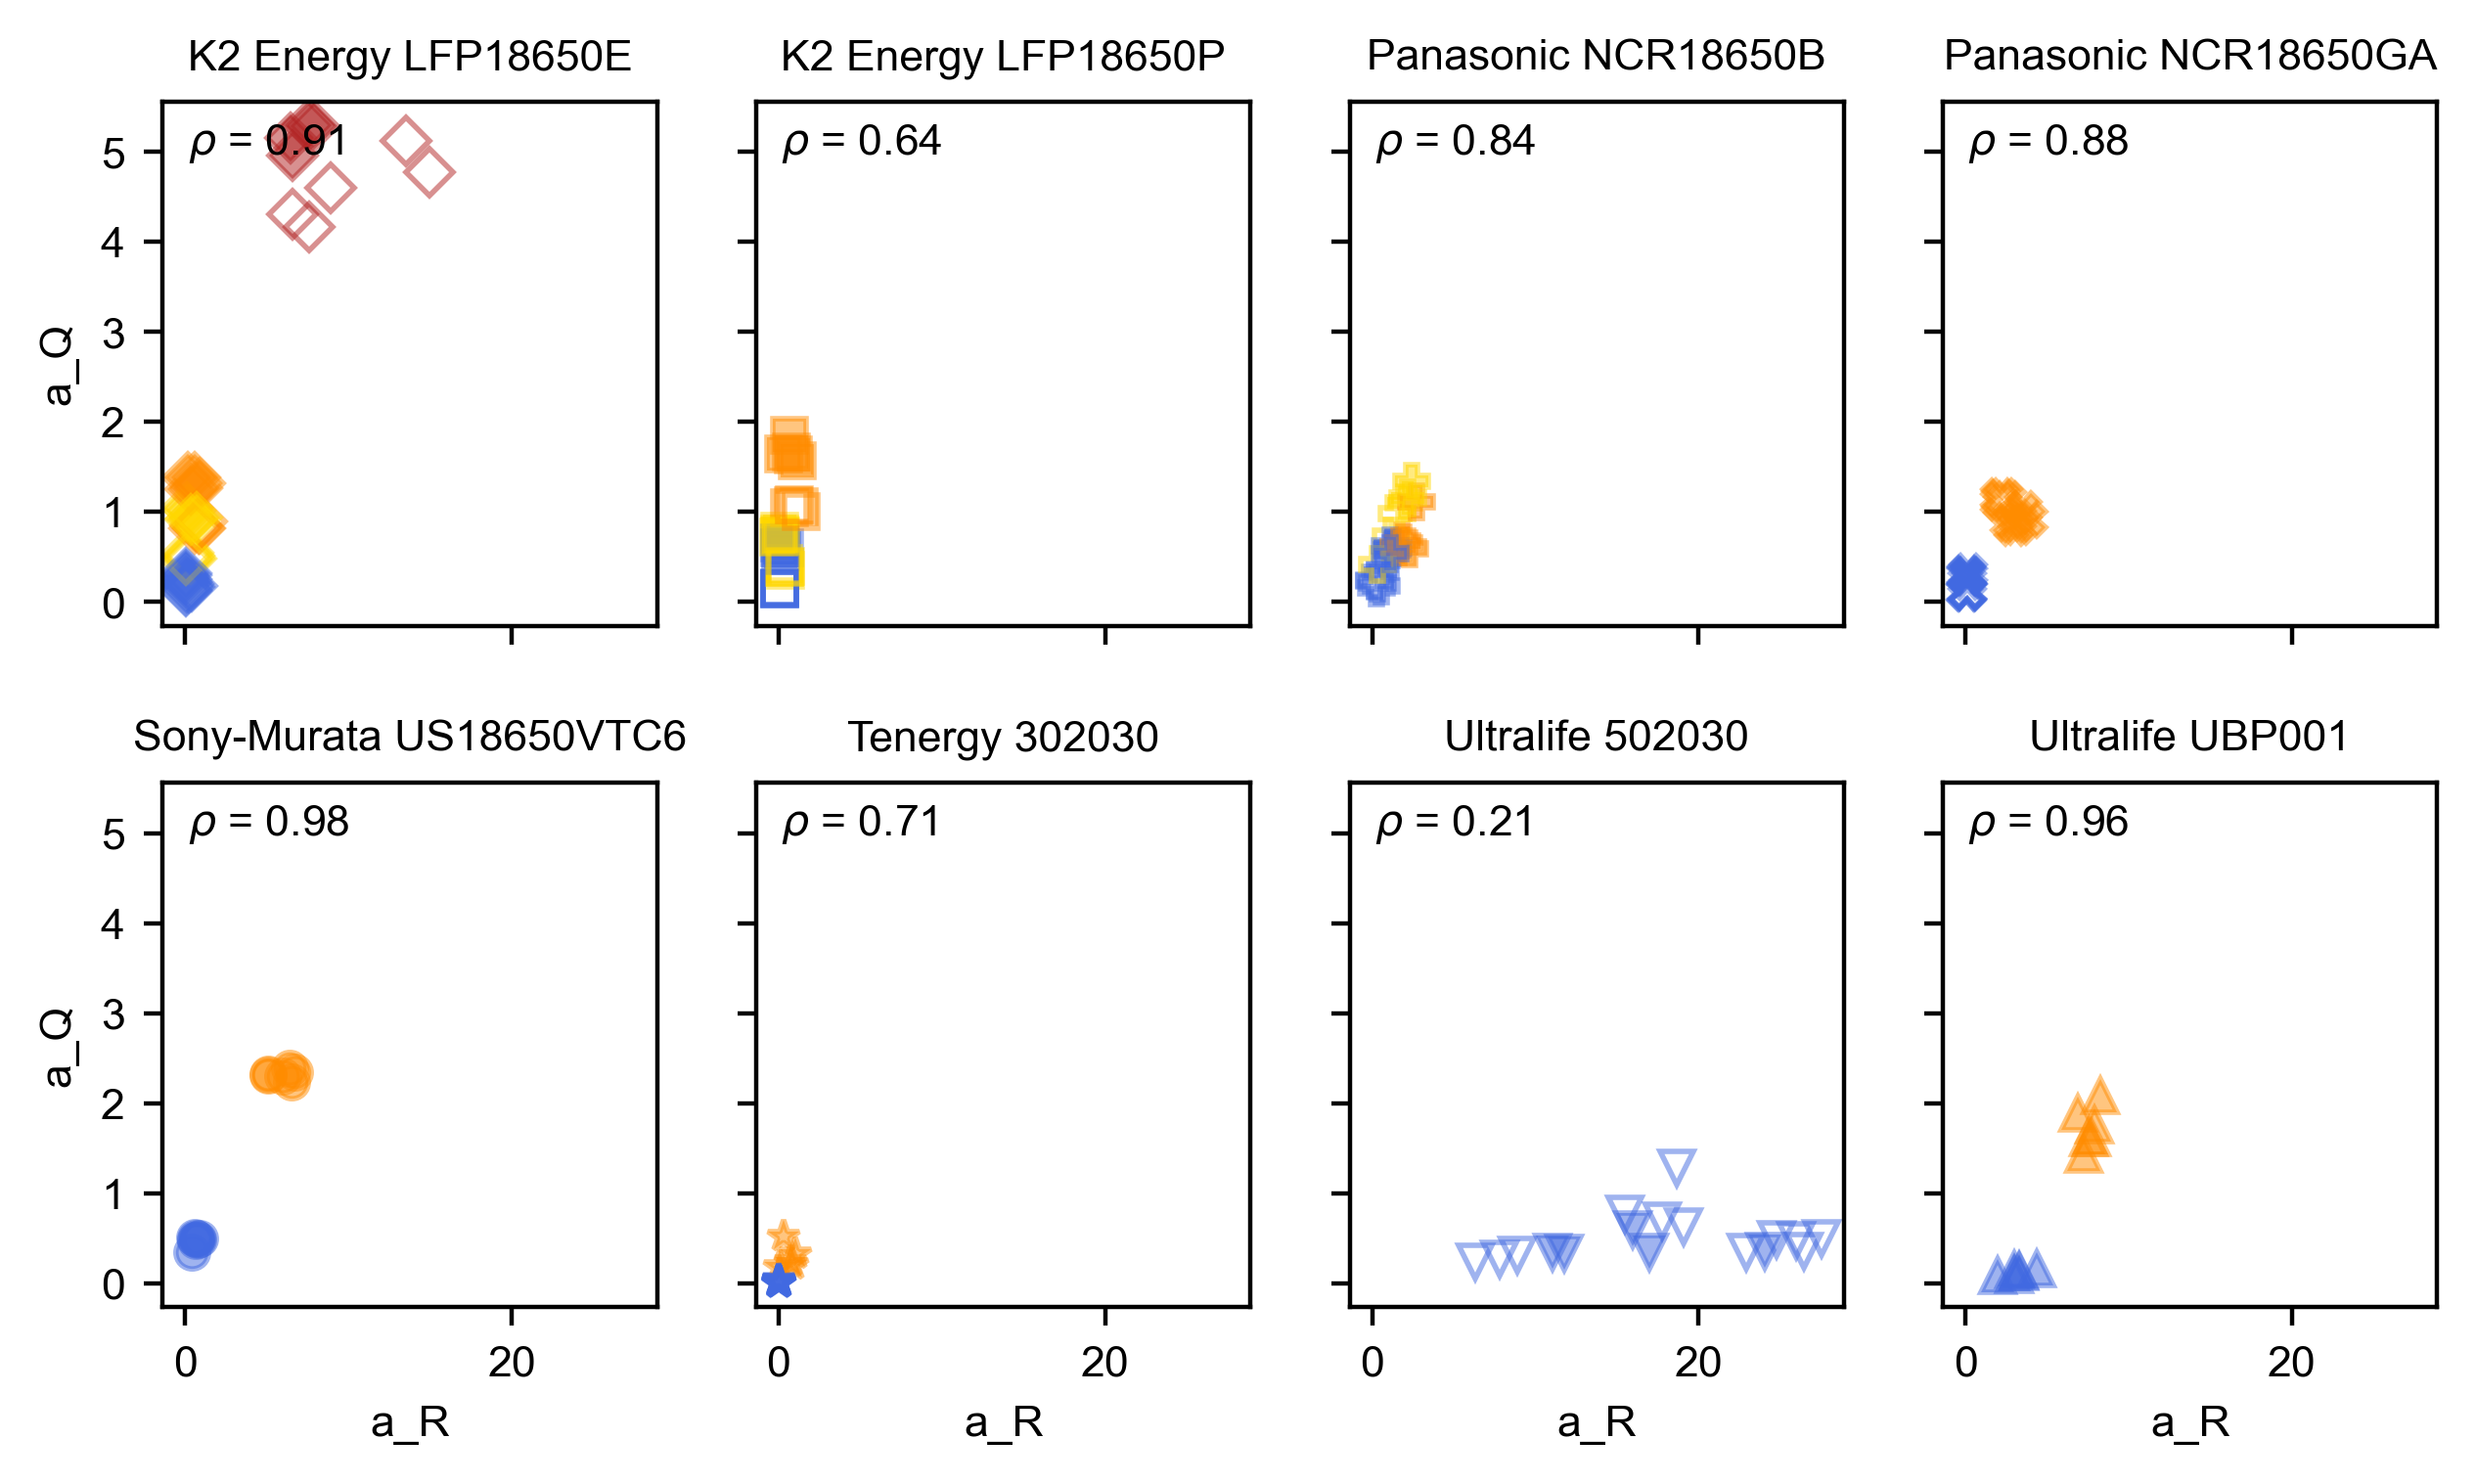

In [22]:
#For a_R vs a_Q for all individual cell types 


fig, axs = plt.subplots(2, 4, figsize=(7.5,4.0), dpi = 400, sharey=True, sharex=True)
axs_ravel = axs.ravel()


for cell_type_idx, cell_type in enumerate(cell_type_list):

    cell_type_cap_res_df = merged_cap_res_df[merged_cap_res_df["Cell_type"]==cell_type]
    ax = axs_ravel[cell_type_idx]
    for idx, row in cell_type_cap_res_df.iterrows():
        temp= row["Temperature"]
        soc= row["SOC"]
        marker_kwargs = {"marker": cell_type_marker_dict[cell_type], "fillstyle":soc_fill_dict[soc], 
            "color":temp_color_dict[temp], "alpha":0.5}
        #Just using errorbar one so kwargs are same
        ax.errorbar(row["a_R"],row["a_Q"], **marker_kwargs)
    


    res = pearsonr(cell_type_cap_res_df["a_Q"], cell_type_cap_res_df["a_R"])
    pearson_val = res.statistic

    ax.text(0.05, 0.9, r"$\rho$ = {:.2f}".format(pearson_val), transform = ax.transAxes)
    ax.set_title("{}".format(cell_type))

plt.subplots_adjust(hspace=0.3)

axs[0,0].set_ylabel(r"a_Q")
axs[1,0].set_ylabel(r"a_Q")

axs[1,0].set_xlabel(r"a_R")
axs[1,1].set_xlabel(r"a_R")
axs[1,2].set_xlabel(r"a_R")
axs[1,3].set_xlabel(r"a_R")

#fig.savefig("../figures/SI_figure_aQvsaR_individual_celltype.svg", format="svg", transparent=True, bbox_inches="tight")

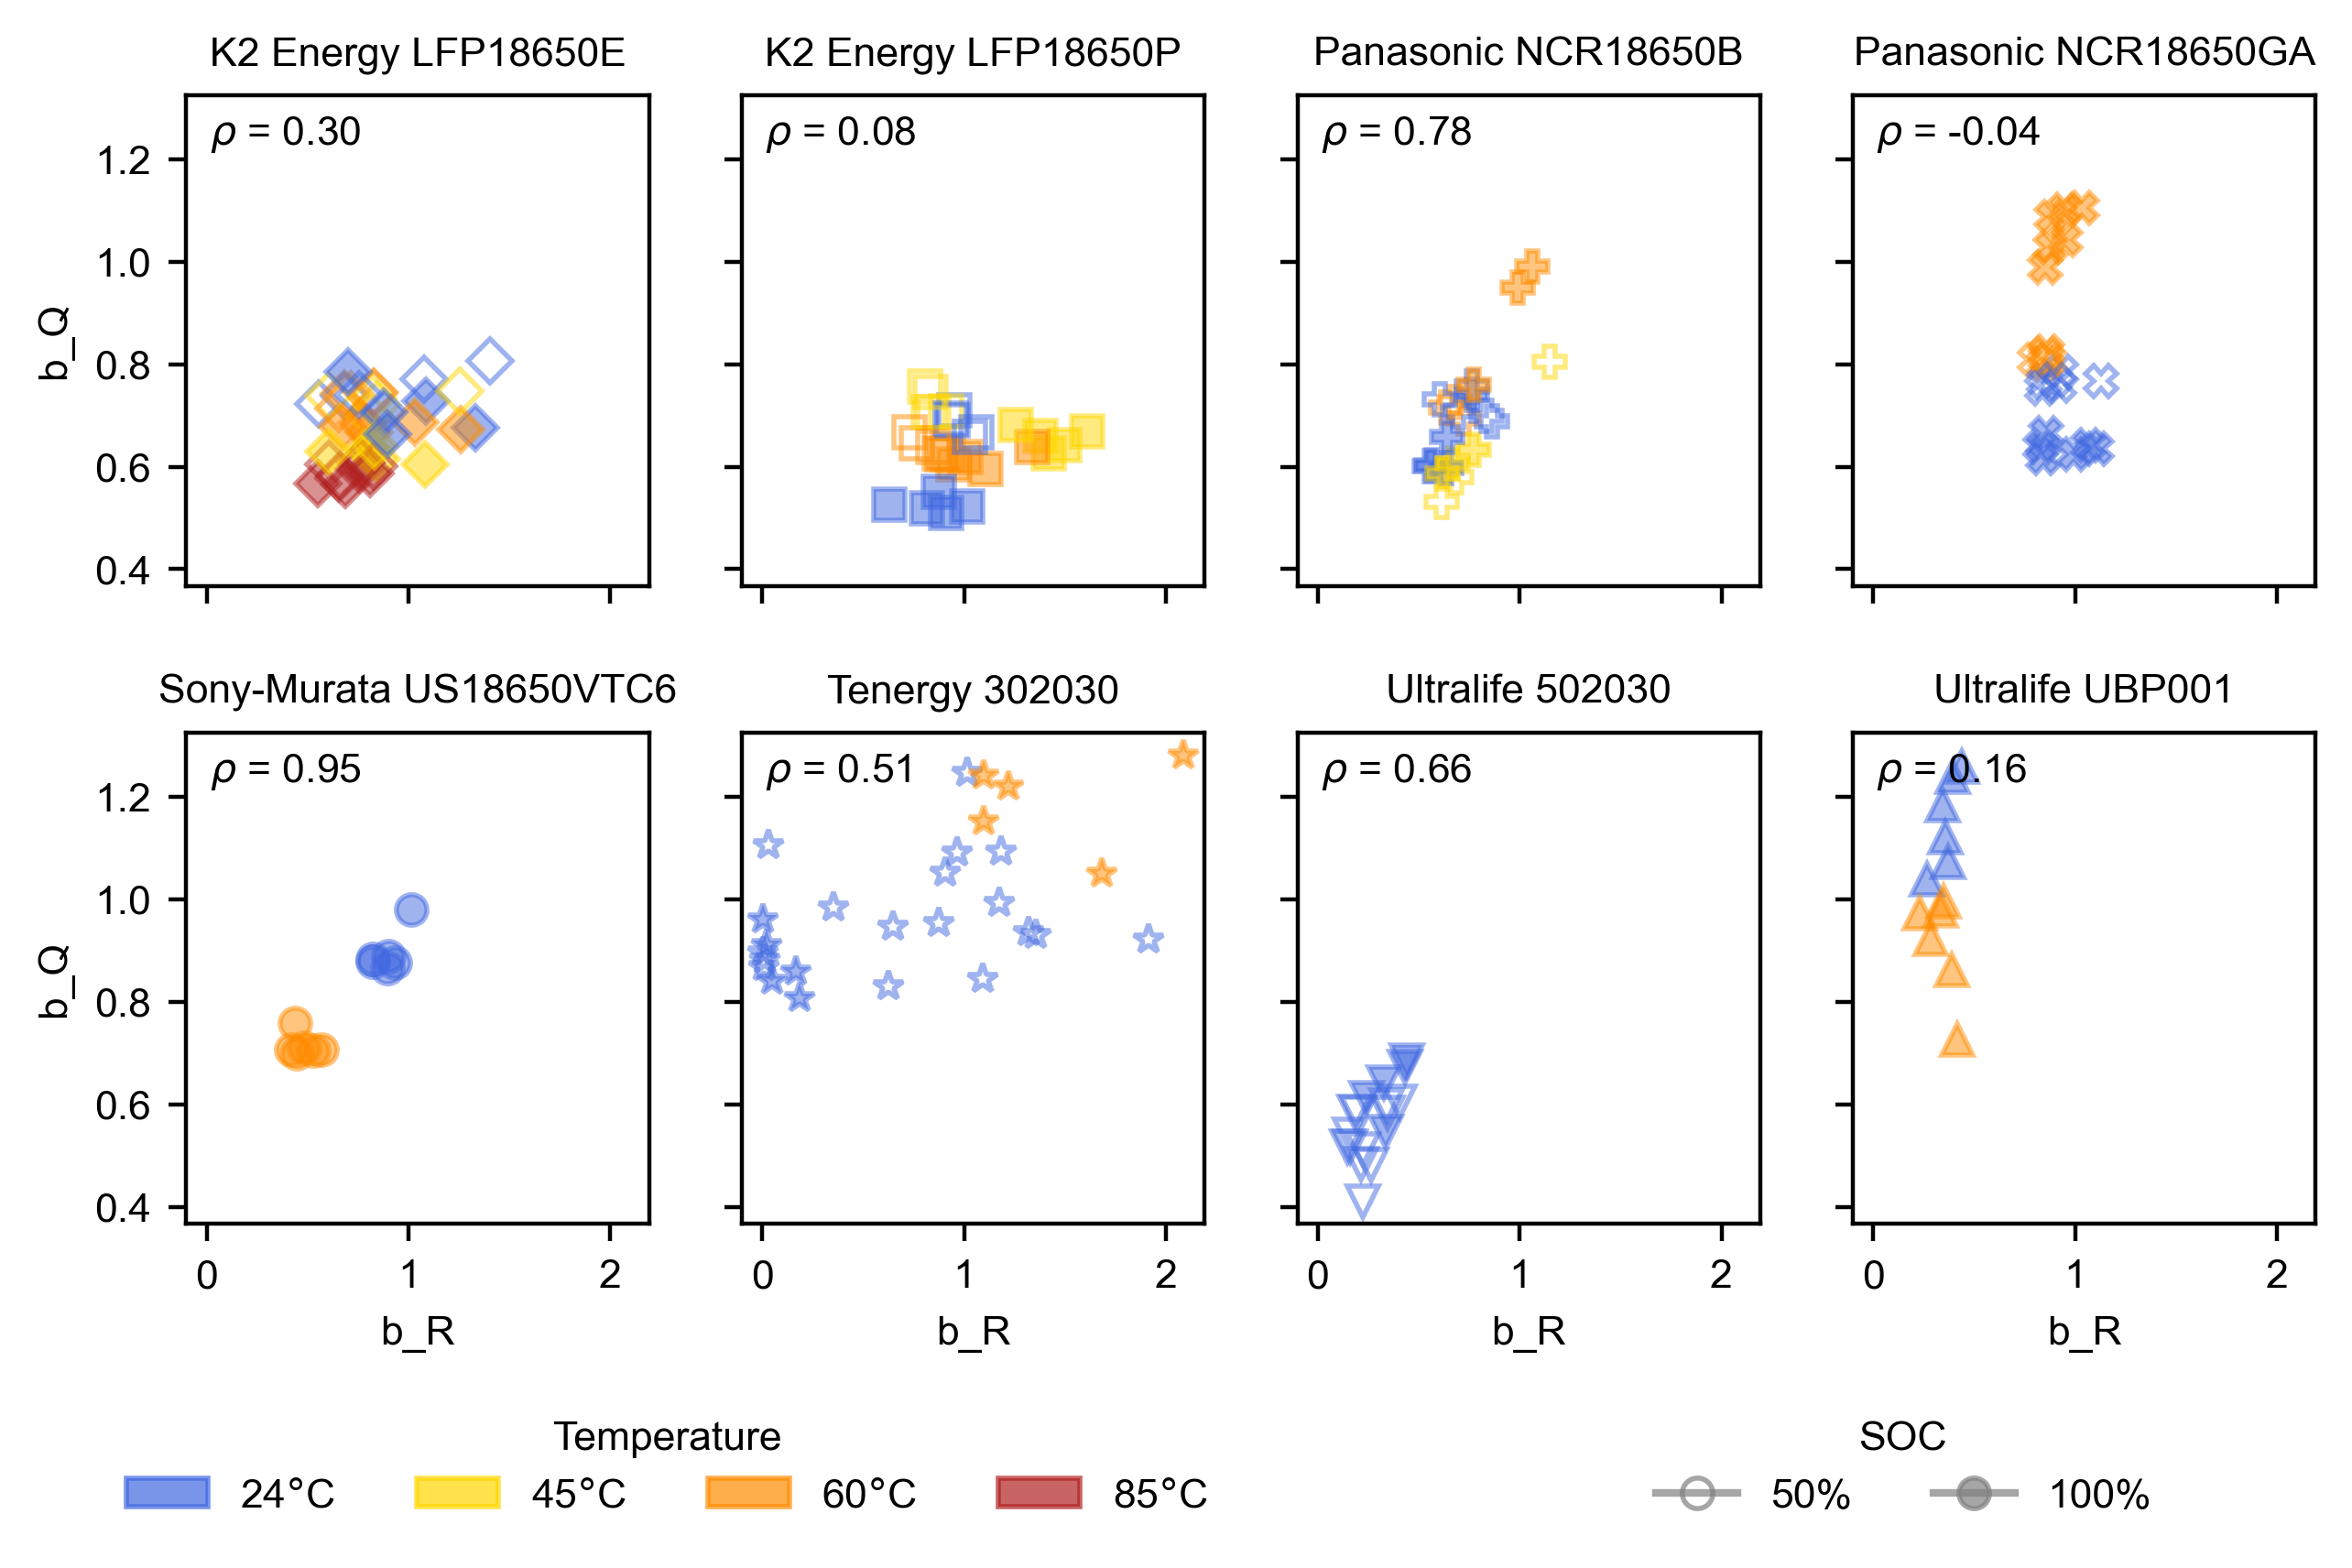

In [23]:

fig, axs = plt.subplots(2, 4, figsize=(7.5,4.0), dpi = 400, sharey=True, sharex=True)
axs_ravel = axs.ravel()


for cell_type_idx, cell_type in enumerate(cell_type_list):

    cell_type_cap_res_df = merged_cap_res_df[merged_cap_res_df["Cell_type"]==cell_type]
    ax = axs_ravel[cell_type_idx]
    for idx, row in cell_type_cap_res_df.iterrows():
        temp= row["Temperature"]
        soc= row["SOC"]
        marker_kwargs = {"marker": cell_type_marker_dict[cell_type], "fillstyle":soc_fill_dict[soc], 
            "color":temp_color_dict[temp], "alpha":0.5}
        #Just using errorbar one so kwargs are same
        ax.errorbar(row["b_R"],row["b_Q"], **marker_kwargs)
    


    res = pearsonr(cell_type_cap_res_df["b_Q"], cell_type_cap_res_df["b_R"])
    pearson_val = res.statistic

    ax.text(0.05, 0.9, r"$\rho$ = {:.2f}".format(pearson_val), transform = ax.transAxes)
    ax.set_title("{}".format(cell_type))

plt.subplots_adjust(hspace=0.3)

axs[0,0].set_ylabel(r"b_Q")
axs[1,0].set_ylabel(r"b_Q")

axs[1,0].set_xlabel(r"b_R")
axs[1,1].set_xlabel(r"b_R")
axs[1,2].set_xlabel(r"b_R")
axs[1,3].set_xlabel(r"b_R")

legend_y = 0
patch_24 = mpatches.Patch(color='royalblue', label=r'24$\degree$C', alpha=0.7)
patch_45 = mpatches.Patch(color='gold', label=r'45$\degree$C', alpha=0.7)
patch_60 = mpatches.Patch(color='darkorange', label=r'60$\degree$C', alpha=0.7)
patch_85 = mpatches.Patch(color='firebrick', label=r'85$\degree$C', alpha=0.7)
temp_handles = [patch_24, patch_45, patch_60, patch_85]
fig.legend(handles=temp_handles, loc='upper center', ncol=4,bbox_to_anchor=(0.3, legend_y), title="Temperature", frameon=False)

line_soc_50 = Line2D([0], [0], label='50%', alpha=0.7, color="gray", marker="o", fillstyle="none")
line_soc_100 = Line2D([0], [0], label='100%', alpha=0.7, color="gray", marker="o", fillstyle="full")
soc_handles = [line_soc_50, line_soc_100]
fig.legend(handles=soc_handles, loc="upper center", ncol=2,bbox_to_anchor=(0.75, legend_y), title= "SOC", frameon=False)


#fig.savefig("../figures/SI_figure_bQvsbR_individual_celltype.svg", format="svg", transparent=True, bbox_inches="tight")

plt.show()